#Context:
---
LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan

This case study will focus on the underwriting process behind Personal Loan only


#Problem Statement
---
Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    auc,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    matthews_corrcoef,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)

#Load Dataset

In [3]:
!gdown 1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d

Downloading...
From: https://drive.google.com/uc?id=1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d
To: /content/logistic_regression.csv
100% 100M/100M [00:02<00:00, 47.2MB/s] 


In [4]:
df = pd.read_csv('/content/logistic_regression.csv')
df_ = df.copy(deep = True)
np.shares_memory(df, df_)

False

#Utility Functions

In [260]:
def evaluate_classifier(y_true, y_pred, y_prob=None, show_plots=True):
    """
    Full classification evaluation.

    Usage:
    y_prob = model.predict_proba(X_test)[:, 1]
    evaluate_classifier(y_test, y_pred, y_prob)
    """

    # ---- Confusion Matrix ----
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tpr = tp / (tp + fn) if (tp + fn) else 0
    tnr = tn / (tn + fp) if (tn + fp) else 0
    fpr_val = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall (TPR)": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "TPR": tpr,
        "TNR": tnr,
        "FPR": fpr_val,
        "FNR": fnr,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }

    print("\nClassification Report\n")
    print(classification_report(y_true, y_pred))

    # ---- Probability metrics ----
    if y_prob is not None:
        metrics["roc_auc"] = roc_auc_score(y_true, y_prob)
        fpr_curve, tpr_curve, _ = roc_curve(y_true, y_prob)

    # ---- Confusion + ROC side-by-side ----
    if show_plots:

        if y_prob is not None:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            ConfusionMatrixDisplay.from_predictions(
                y_true, y_pred, ax=axes[0]
            )
            axes[0].set_title("Confusion Matrix")

            axes[1].plot(fpr_curve, tpr_curve)
            axes[1].plot([0, 1], [0, 1], linestyle="--")
            axes[1].set_xlabel("False Positive Rate")
            axes[1].set_ylabel("True Positive Rate")
            axes[1].set_title("ROC Curve")

            plt.tight_layout()
            plt.show()

        else:
            ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
            plt.title("Confusion Matrix")
            plt.show()

    # ---- PR and Threshold curves ----
    if y_prob is not None:

        pr_precision, pr_recall, thresholds = precision_recall_curve(
            y_true, y_prob
        )
        metrics["pr_auc"] = auc(pr_recall, pr_precision)

        if show_plots:
            diff = np.abs(pr_precision[:-1] - pr_recall[:-1])
            idx = np.argmin(diff)

            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # PR curve
            axes[0].plot(pr_recall, pr_precision)
            axes[0].scatter(
                pr_recall[idx],
                pr_precision[idx],
                label=f"thr={thresholds[idx]:.3f}"
            )
            axes[0].set_title("Precision–Recall Curve")
            axes[0].set_xlabel("Recall")
            axes[0].set_ylabel("Precision")
            axes[0].legend()

            # Threshold curves
            axes[1].plot(thresholds, pr_precision[:-1], label="Precision")
            axes[1].plot(thresholds, pr_recall[:-1], label="Recall")
            axes[1].set_title("Precision & Recall vs Threshold")
            axes[1].set_xlabel("Threshold")
            axes[1].set_ylabel("Score")
            axes[1].legend()

            plt.tight_layout()
            plt.show()

    # ---- Print metrics ----
    for k, v in metrics.items():
        print(f"{k}: {v}")

In [7]:
def plot_model_weights(coef_df, fig_size=(8, 5), use_abs=False):
    """
    Plot feature weights from regression models.

    Parameters
    ----------
    coef_df : pd.DataFrame
        Must contain columns:
        - Feature
        - Coefficient
        - Abs_Coefficient

    fig_size : tuple
        Figure size.

    use_abs : bool
        If True, plots absolute coefficients.
        If False, plots signed coefficients.
    """

    sns.set_theme(
        style="dark",
        rc={
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "font.size": 9,
        },
    )

    value_col = "Abs_Coefficient" if use_abs else "Coefficient"
    title = "Feature Weights (Absolute)" if use_abs else "Feature Weights (Signed)"

    # sort for better visualization
    coef_df_plot = coef_df.sort_values(value_col, ascending=False)

    plt.figure(figsize=fig_size)

    sns.barplot(
        data=coef_df_plot,
        x=value_col,
        y="Feature",
        palette="viridis",
        hue="Feature",
        dodge=False,
        legend=False
    )

    plt.title(title, pad=8)
    plt.xlabel(value_col.replace("_", " "))
    plt.ylabel("")

    # annotate values
    for i, v in enumerate(coef_df_plot[value_col]):
        offset = 0.01 if v >= 0 else -0.01
        ha = "left" if v >= 0 else "right"

        plt.text(
            v + offset,
            i,
            f"{v:.4f}",
            va="center",
            ha=ha,
            fontsize=8,
            color="black",
        )

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


In [8]:
def model_weights(model, X=None):
    """
    Extract logistic regression weights.

    Works for:
    - Pipeline models
    - Non-pipeline models

    Parameters
    ----------
    model : fitted model or pipeline
    X : feature dataframe (required if non-pipeline)

    Returns
    -------
    DataFrame of sorted coefficients
    """

    # ---- Pipeline case ----
    if hasattr(model, "named_steps"):
        feature_names = (
            model.named_steps["preprocess"]
            .get_feature_names_out()
        )
        clf = model.named_steps["clf"]

    # ---- Non-pipeline case ----
    else:
        if X is None:
            raise ValueError(
                "For non-pipeline models, pass X dataframe."
            )

        feature_names = X.columns
        clf = model

    coefficients = clf.coef_[0]
    sign = np.sign(coefficients)

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients,
        "Abs_Coefficient": np.abs(coefficients),
        "Sign": sign
    })

    coef_df = coef_df.sort_values(
        by="Abs_Coefficient",
        ascending=False
    )

    return coef_df


In [9]:
def null_summary(df, cols=None):
    """
    Returns null count and null percentage for given columns.

    Parameters
    ----------
    df : pandas.DataFrame
    cols : list or None
        Columns to check. If None → all columns.
    """

    if cols is None:
        cols = df.columns

    result = pd.DataFrame({
        "null_count": df[cols].isna().sum(),
        "null_percent": (df[cols].isna().mean() * 100).round(2)
    })

    return result.sort_values("null_percent", ascending=False)

In [10]:
def numerical_columns_distribution_with_stats(df, cols = None):
    """
    Generates and displays histograms, boxplots, and density plots for numerical columns
    in a DataFrame, along with key descriptive statistics.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cols (list, optional): A list of numerical column names to plot. If None,
                             it defaults to all numerical columns (excluding object, category, datetime dtypes).
    """
    if cols is None:
        cols=df.select_dtypes(exclude=['object', 'category', 'datetime']).columns
    for col in cols:

      data = df[col].dropna()

      # Calculate statistics
      mean_val = data.mean()
      median_val = data.median()
      std_val = data.std()
      min_val = data.min()
      max_val = data.max()

      # Print statistics
      print(f"Statistics for {col}:")
      print(f"  Mean   : {mean_val:.2f}")
      print(f"  Median : {median_val:.2f}")
      print(f"  Std Dev: {std_val:.2f}")
      print(f"  Min    : {min_val:.2f}")
      print(f"  Max    : {max_val:.2f}")

      plt.figure(figsize=(15, 5))

      # Histogram
      plt.subplot(1, 3, 1)
      #plt.hist(data, bins=30, color='skyblue', edgecolor='black')
      sns.histplot(
        data=df,             # your DataFrame
        x=data,        # column to plot
        bins=30,             # number of bins
        kde=True,            # add kernel density estimate
        color='royalblue',   # bar color
        edgecolor='black',   # edge of bars
        stat='density'       # normalize histogram to density (optional)
        )
      plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
      plt.axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
      plt.title(f"Histogram of {col}")
      plt.xlabel(f"{col} Amount")
      plt.ylabel("Frequency")
      plt.legend()

      # Boxplot
      plt.subplot(1, 3, 2)
      sns.boxplot(x=data, color='orange')
      plt.title(f"Boxplot of {col}")
      plt.xlabel(f"{col} Amount")
      plt.text(mean_val, 0.02, f"Mean: {mean_val:.2f}", ha='center', color='red')
      plt.text(median_val, -0.05, f"Median: {median_val:.2f}", ha='center', color='green')

      # Density plot
      plt.subplot(1, 3, 3)
      sns.kdeplot(data, fill=True, color='green')
      plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
      plt.axvline(median_val, color='blue', linestyle='--', label=f"Median: {median_val:.2f}")
      plt.title(f"Density Plot of {col}")
      plt.xlabel(f"{col} Amount")
      plt.legend()

      plt.tight_layout()
      plt.show()

In [11]:
def iqr_outliers_boxplot(df, cols=None):
    """
    Detects outliers in numeric columns using the IQR method
    and reports counts + percentages.
    """
    import seaborn as sns

    sns.set_palette("deep")

    if cols is None:
        cols = df.select_dtypes(
            exclude=["object", "category", "datetime"]
        ).columns

    n = len(df)

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        below = (df[col] < lower).sum()
        above = (df[col] > upper).sum()
        total = below + above

        print(f"\nColumn: {col}")
        print(f"Below lower bound {lower} : {below} ({below/n:.2%})")
        print(f"Above upper bound {upper} : {above} ({above/n:.2%})")
        print(f"Total outliers    : {total} ({total/n:.2%})")


In [12]:

def plot_categorical(
    df,
    cols,
    hue_col="loan_status",
    sort=True,
    sort_index=False,
    palette="deep",
    figsize=(12, 5),
    show_nulls=True
):
    """
    Horizontal seaborn countplots (2 per row)
    - Hue support
    - Count labels
    - Optional null category plotting
    """

    n = len(cols)
    rows = (n + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):

        # ---- Create temp series for plotting ----
        if show_nulls:
            plot_series = df[col].astype(object).fillna("Missing")
        else:
            plot_series = df[col]

        temp_df = df.copy()
        temp_df[col] = plot_series

        if sort_index:
            order = temp_df[col].value_counts(dropna= False).sort_index().index
        else:
            order = temp_df[col].value_counts(dropna= False).index if sort else temp_df[col].unique()

        sns.countplot(
            data=temp_df,
            y=col,
            hue=hue_col,
            order=order,
            palette=palette,
            ax=axes[i]
        )

        axes[i].set_title(f"{col} vs {hue_col}")

        # ---- Add count labels ----
        for p in axes[i].patches:
            width = p.get_width()
            if width > 0:
                axes[i].text(
                    width,
                    p.get_y() + p.get_height()/2,
                    f"{int(width)}",
                    va="center",
                    ha="left",
                    fontsize=9
                )

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    del temp_df
    plt.tight_layout()
    plt.show()


#Analysis

In [13]:
df.shape

(396030, 27)

Dataset contains rows - `396030` and columns - `27`

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [15]:
df.head(3)

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   

         emp_title emp_length home_ownership  annual_inc verification_status  \
0        Marketing  10+ years           RENT    117000.0        Not Verified   
1  Credit analyst     4 years       MORTGAGE     65000.0        Not Verified   
2     Statistician   < 1 year           RENT     43057.0     Source Verified   

    issue_d loan_status             purpose                    title    dti  \
0  Jan-2015  Fully Paid            vacation                 Vacation  26.24   
1  Jan-2015  Fully Paid  debt_consolidation       Debt consolidation  22.05   
2  Jan-2015  Fully Paid         credit_card  Credit card refinancing  12.79   

  earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0         Jun-1990      16.0      0.0    36369.0        41.8       25.0   
1         Jul-2004      17.0      0.0    20131.0        53.3       27.0   
2         Aug-2007      13.0      0.0    11987.0        92.2       26.0   

  initial_list_status application_type  mort_acc  pub_rec_bankruptcies  \
0                   w       INDIVIDUAL       0.0                   0.0   
1                   f       INDIVIDUAL       3.0                   0.0   
2                   f       INDIVIDUAL       0.0                   0.0   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113


**Column Profiling**

1. `loan_amnt` : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. `term` : The number of payments on the loan. Values are in months and can be either 36 or 60.
3. `int_rate` : Interest Rate on the loan
4. `installment` : The monthly payment owed by the borrower if the loan originates.
5. `grade` : LoanTap assigned loan grade
6. `sub_grade` : LoanTap assigned loan subgrade
7. `emp_title` :The job title supplied by the Borrower when applying for the loan.*
8. `emp_length` : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
9. `home_ownership` : The home ownership status provided by the borrower during registration or obtained from the credit report.
10. `annual_inc` : The self-reported annual income provided by the borrower during registration.
11. `verification_status` : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
12. `issue_d` : The month which the loan was funded
13. `loan_status` : Current status of the loan - `Target Variable`
14. `purpose` : A category provided by the borrower for the loan request.
15. `title` : The loan title provided by the borrower
16. `dti` : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
17. `earliest_cr_line` :The month the borrower's earliest reported credit line was opened
18. `open_acc` : The number of open credit lines in the borrower's credit file.
19. `pub_rec` : Number of derogatory public records
20. `revol_bal` : Total credit revolving balance
21. `revol_util` : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
22. `total_acc` : The total number of credit lines currently in the borrower's credit file
23. `initial_list_status` : The initial listing status of the loan. Possible values are – W, F
24. `application_type` : Indicates whether the loan is an individual application or a joint application with two co-borrowers
25. `mort_acc` : Number of mortgage accounts.
26. `pub_rec_bankruptcies` : Number of public record bankruptcies
27. `Address` : Address of the individual

In [16]:
df.duplicated().sum()

np.int64(0)

Dataset has no duplicate records.

In [17]:
drop_cols = [] # contains cols to be dropped

robust_cols = [] # contains cols that robust scaled

null_std_cols = [] # contains cols that will be standard scaled after null imputation(median)

ordinal_cols = {} # contains cols that will be ordinal encoded
null_ordinal_cols = {} # contains cols that will be ordinal encoded after null imputation

binary_flag_col = [] # contains cols that will be binary flagged(0,1)
ohe_cols = [] # contains cols that will be one-hot-encoded

state_ohe_cols = [] # contains cols that will be one-hot-encoded after state extraction

##`1. loan_amnt`

In [18]:
df.loan_amnt.describe()

count    396030.000000
mean      14113.888089
std        8357.441341
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Statistics for loan_amnt:
  Mean   : 14113.89
  Median : 12000.00
  Std Dev: 8357.44
  Min    : 500.00
  Max    : 40000.00


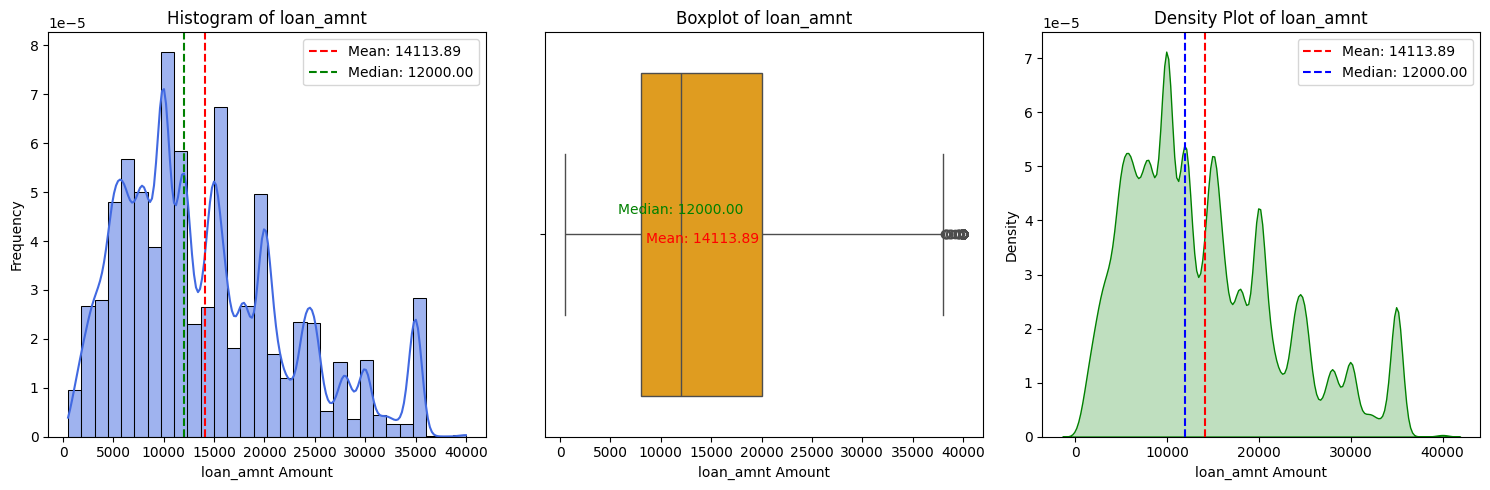

In [19]:
numerical_columns_distribution_with_stats(df, ['loan_amnt'])

In [20]:
null_summary(df, ['loan_amnt'])

null_count  null_percent
loan_amnt           0           0.0

`loan_amnt` column has no null values.

In [21]:
iqr_outliers_boxplot(df, cols = ['loan_amnt'])


Column: loan_amnt
Below lower bound -10000.0 : 0 (0.00%)
Above upper bound 38000.0 : 191 (0.05%)
Total outliers    : 191 (0.05%)


In [22]:
df.loan_amnt.skew()

np.float64(0.777285467097746)

loan amounts skewed right

Around 191 outliers above 38000 loan_amnt , these very large loans might be VIP borrowers, these are not error, rather they're often profitable.

So we will `robust scale`.

In [23]:
robust_cols.append('loan_amnt')

##`2. term`

In [24]:
df['term'].value_counts(dropna= False)

term
36 months    302005
60 months     94025
Name: count, dtype: int64

In [25]:
null_summary(df, ['term'])

null_count  null_percent
term           0           0.0

`term` column has no null values.

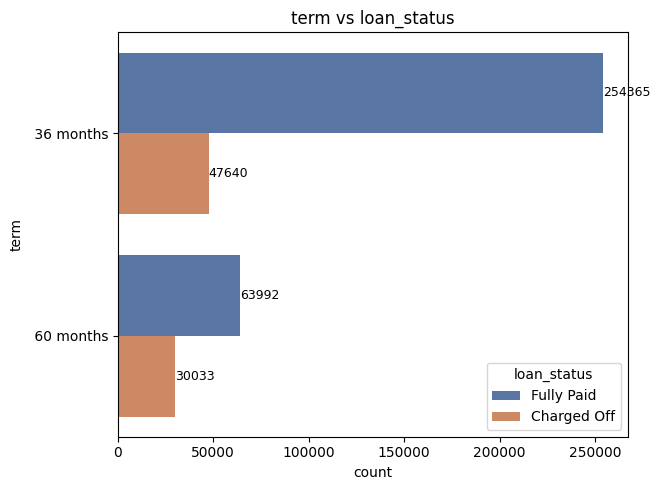

In [26]:
plot_categorical(df, ['term'])

This `term` cols has no null values and a categorical col with 2 category. So we will `One-Hot-Encode` this col.

In [27]:
ohe_cols.append('term')

##`3. int_rate`

In [28]:
null_summary(df, ['int_rate'])

null_count  null_percent
int_rate           0           0.0

In [29]:
df.int_rate.describe()

count    396030.000000
mean         13.639400
std           4.472157
min           5.320000
25%          10.490000
50%          13.330000
75%          16.490000
max          30.990000
Name: int_rate, dtype: float64

Statistics for int_rate:
  Mean   : 13.64
  Median : 13.33
  Std Dev: 4.47
  Min    : 5.32
  Max    : 30.99


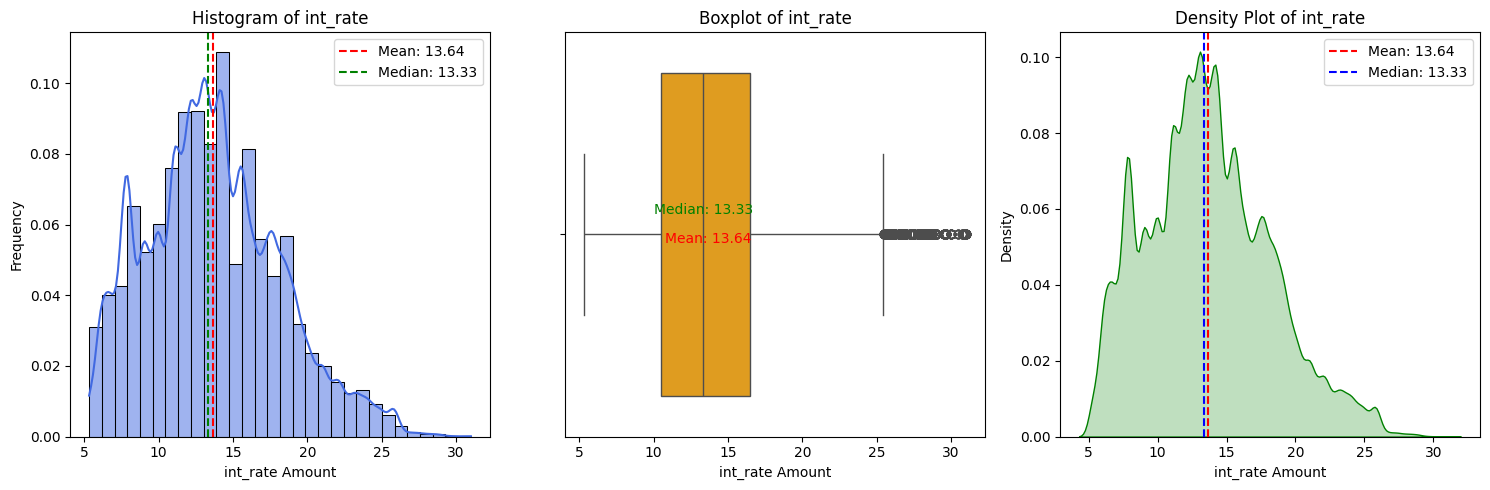

In [30]:
numerical_columns_distribution_with_stats(df, ['int_rate'])

In [31]:
df.int_rate.skew()

np.float64(0.4206694719582165)

In [32]:
iqr_outliers_boxplot(df, cols = ['int_rate'])


Column: int_rate
Below lower bound 1.4900000000000038 : 0 (0.00%)
Above upper bound 25.489999999999995 : 3777 (0.95%)
Total outliers    : 3777 (0.95%)


- Risky borrowers get penalized upward, not downward
- High interest is not bad data rather it's the business model.

So `int_rate` will be `Robust Scaled`

In [33]:
robust_cols.append('int_rate')

##`4. installment`

In [34]:
null_summary(df, ['installment'])

null_count  null_percent
installment           0           0.0

In [35]:
df.head(1)

loan_amnt        term  int_rate  installment grade sub_grade  emp_title  \
0    10000.0   36 months     11.44       329.48     B        B4  Marketing   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years           RENT    117000.0        Not Verified  Jan-2015   

  loan_status   purpose     title    dti earliest_cr_line  open_acc  pub_rec  \
0  Fully Paid  vacation  Vacation  26.24         Jun-1990      16.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   

                                          address  
0  0174 Michelle Gateway\r\nMendozaberg, OK 22690

In [36]:
def installment(loan_amnt, int_rate, term):
    int_rate = int_rate / (12 * 100)
    emi = loan_amnt * (int_rate * (1 + int_rate) ** term) / ((1 + int_rate) ** term - 1)
    return np.round(emi,2)

In [37]:
installment(10000, 11.44, 36)

np.float64(329.47)

As the `installment` column can be mathematically derived from `loan_amt`, `term` and `int_rate` columns, we can't keep all four columns in out dataset to train logistic regression model as it will create `multi-colinearity`. Even though prediction will work fine but weights can't be used for decision making.

So we will drop `installment` cols.

We can also verify the `multicolinearity` using vif

In [38]:
vif_cols = ['loan_amnt', 'term', 'int_rate', 'installment']

In [39]:
df_vif = df[vif_cols].copy()

df_vif['term'] = (
    df_vif['term']
    .astype(str)
    .str.strip()
    .map({'36 months': 0, '60 months': 1})
    .astype('int64')
)


In [40]:
vif = pd.DataFrame()
vif['Features'] = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif, i) for i in range(df_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0    loan_amnt  169.15
3  installment  162.25
1         term    5.96
2     int_rate    4.91

As vif values is > 5, there is multicolinearity.

In [41]:
df_vif.drop('installment', axis = 1, inplace = True)

In [42]:
vif = pd.DataFrame()
vif['Features'] = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0  loan_amnt  3.69
2   int_rate  3.61
1       term  1.60

After removing the `installment` column, multicolinearity removed.

In [43]:
drop_cols.append('installment')

##`5. grade`

In [44]:
null_summary(df, ['grade'])

null_count  null_percent
grade           0           0.0

In [45]:
df['grade'].value_counts(dropna= False)

grade
B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: count, dtype: int64

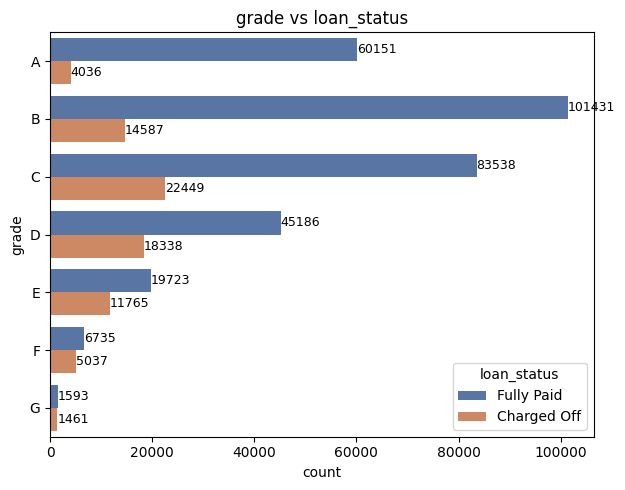

In [46]:
plot_categorical(df, ['grade'], sort_index=True)

grade (A, B, C, D, E, F, G) is ordinal:

A < B < C < D < E < F < G

(lower risk -> higher risk)

As the next column contains the exact information as this we will drop this.

In [47]:
drop_cols.append('grade')

##`6. sub_grade`

In [48]:
null_summary(df, ['sub_grade'])

null_count  null_percent
sub_grade           0           0.0

In [49]:
df['sub_grade'].value_counts(dropna= False).sort_index()

sub_grade
A1     9729
A2     9567
A3    10576
A4    15789
A5    18526
B1    19182
B2    22495
B3    26655
B4    25601
B5    22085
C1    23662
C2    22580
C3    21221
C4    20280
C5    18244
D1    15993
D2    13951
D3    12223
D4    11657
D5     9700
E1     7917
E2     7431
E3     6207
E4     5361
E5     4572
F1     3536
F2     2766
F3     2286
F4     1787
F5     1397
G1     1058
G2      754
G3      552
G4      374
G5      316
Name: count, dtype: int64

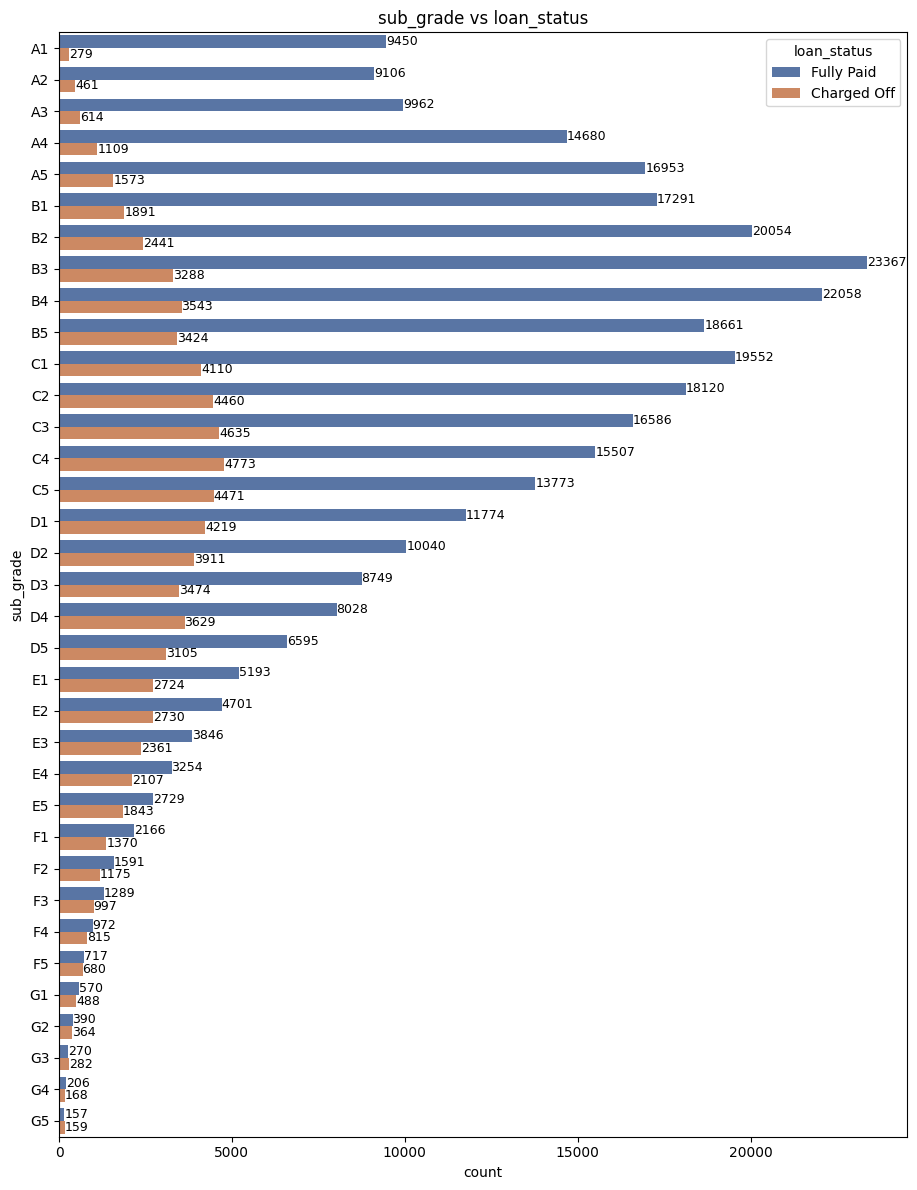

In [50]:
plot_categorical(df, ['sub_grade'],sort_index = True, figsize=(18,12))

In [51]:
sub_grade_col = ["sub_grade"]
sub_grade_order = [
    f"{g}{i}"
    for g in ["A", "B", "C", "D", "E", "F", "G"]
    for i in range(1, 6)
]
print(' < '.join(sub_grade_order))

A1 < A2 < A3 < A4 < A5 < B1 < B2 < B3 < B4 < B5 < C1 < C2 < C3 < C4 < C5 < D1 < D2 < D3 < D4 < D5 < E1 < E2 < E3 < E4 < E5 < F1 < F2 < F3 < F4 < F5 < G1 < G2 < G3 < G4 < G5


Each `grade` has 5 `sub_grade`s

`A1 < A2 < A3 < A4 < A5 < B1 < B2 < B3 < B4 < B5 < C1 < C2 < C3 < C4 < C5 < D1 < D2 < D3 < D4 < D5 < E1 < E2 < E3 < E4 < E5 < F1 < F2 < F3 < F4 < F5 < G1 < G2 < G3 < G4 < G5`

(lower risk -> higher risk)

We will also do a `OrdinalEncode` this col.

In [52]:
ordinal_cols['sub_grade'] = sub_grade_order

##`7. emp_title`

In [53]:
null_summary(df, ['emp_title'])

null_count  null_percent
emp_title       22927          5.79

In [54]:
df['emp_title'].value_counts(dropna= False)

emp_title
NaN                        22927
Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
                           ...  
SVP, Technology                1
sikorsky                       1
Postman                        1
McCarthy & Holthus, LLC        1
Atrium Medical                 1
Name: count, Length: 173106, dtype: int64

We will just drop this col, it has lots of category and no order between them, so can't ohe as high cardinality.

In [55]:
drop_cols.append('emp_title')

##`8. emp_length`

In [56]:
null_summary(df, ['emp_length'])

null_count  null_percent
emp_length       18301          4.62

In [57]:
df['emp_length'].value_counts(dropna= False).sort_index()

emp_length
1 year        25882
10+ years    126041
2 years       35827
3 years       31665
4 years       23952
5 years       26495
6 years       20841
7 years       20819
8 years       19168
9 years       15314
< 1 year      31725
NaN           18301
Name: count, dtype: int64

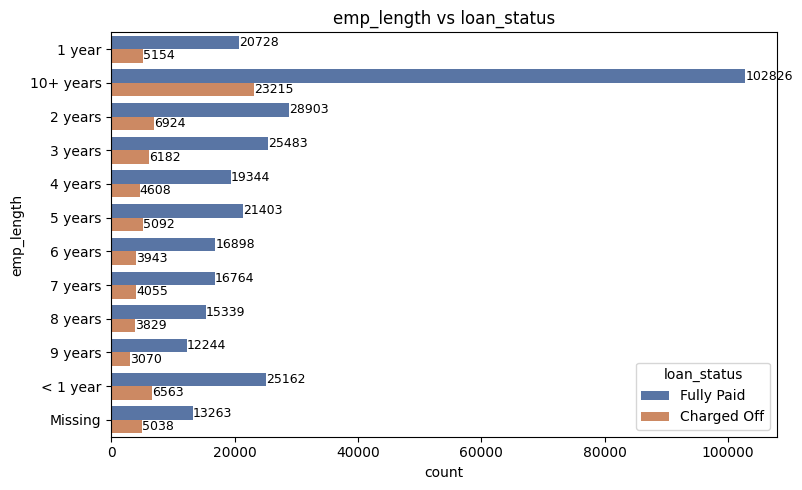

In [58]:
plot_categorical(df, ['emp_length'],sort_index = True, figsize=(15,5))

Null can mean:
- unemployed / unstable work history
- self-employed but not declared
- data missing at source
- borrower skipped question

We can't remove the null as missingness itself can carry above signal.

we will  treat null as its own bucket and Add "Missing" category.

In [59]:
emp_length_order = [
    "Missing",
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years"
]

More work experience -> usually means:
- more income stability
- lower default probability

In the pipeline stage we will impute this col with 'Missing' then we will `Ordinal Encode` this as this have a inherent order like `grade` and `sub-grade`.

In [60]:
null_ordinal_cols['emp_length'] = emp_length_order

##`9. home_ownership`

In [61]:
null_summary(df, ['home_ownership'])

null_count  null_percent
home_ownership           0           0.0

In [62]:
df['home_ownership'].value_counts(dropna= False)

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

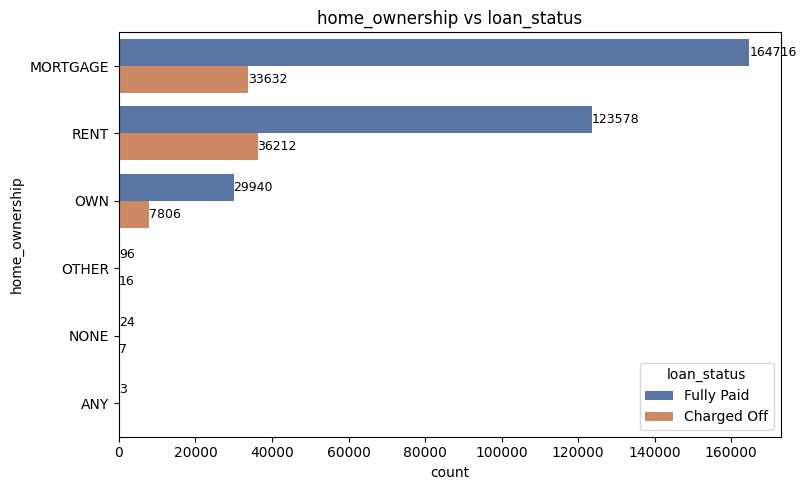

In [63]:
plot_categorical(df, ['home_ownership'], figsize=(15,5))

We will `OneHotEncode` this columns, as there is no inherent order between them.

Reason: Mortgage might seem higher risk than rest but it is also sign that higher income of borrower means less likely to default.

In [64]:
ohe_cols.append('home_ownership')

##`10. annual_inc`

In [65]:
null_summary(df, ['annual_inc'])

null_count  null_percent
annual_inc           0           0.0

In [66]:
df['annual_inc'].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

Statistics for annual_inc:
  Mean   : 74203.18
  Median : 64000.00
  Std Dev: 61637.62
  Min    : 0.00
  Max    : 8706582.00


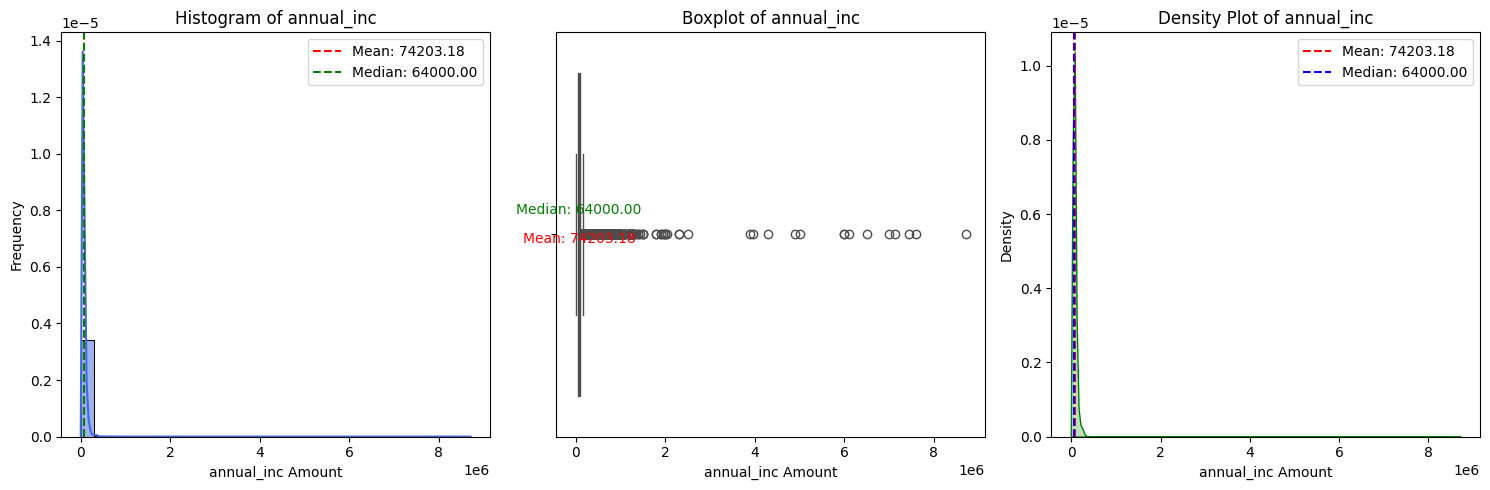

In [67]:
numerical_columns_distribution_with_stats(df, ['annual_inc'])

In [68]:
iqr_outliers_boxplot(df, cols = ['annual_inc'])


Column: annual_inc
Below lower bound -22500.0 : 0 (0.00%)
Above upper bound 157500.0 : 16700 (4.22%)
Total outliers    : 16700 (4.22%)


In [69]:
df['annual_inc'].skew()

np.float64(41.042724746560665)

This columns is right skewed and contains 4.2% outliers so we will Robust Scale it.

In [70]:
robust_cols.append('annual_inc')

##`11. verification_status`

In [71]:
null_summary(df, ['verification_status'])

null_count  null_percent
verification_status           0           0.0

In [72]:
df['verification_status'].value_counts(dropna= False)

verification_status
Verified           139563
Source Verified    131385
Not Verified       125082
Name: count, dtype: int64

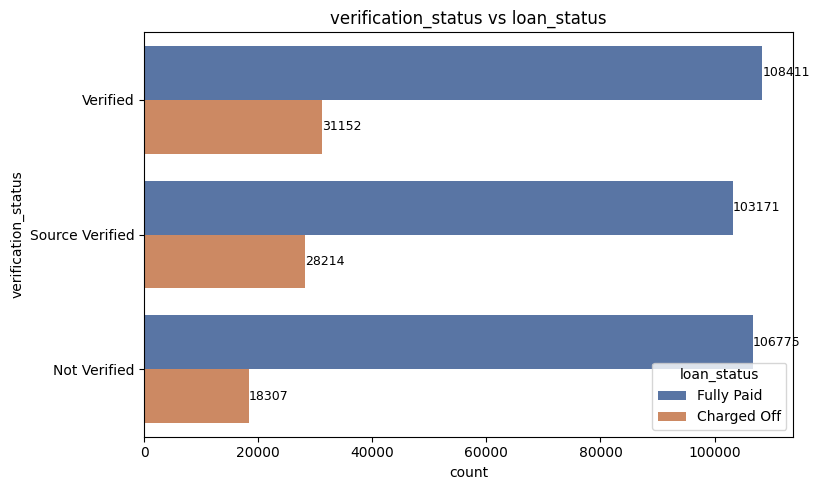

In [73]:
plot_categorical(df, ['verification_status'], figsize=(15,5))

We will OneHotEncode this column, because it might seem a ordinal but
- Some verified incomes are risky (fake docs exist)
- Some unverified incomes belong to stable borrowers

In [74]:
ohe_cols.append('verification_status')

##`12. issue_d`

In [75]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format = '%b-%Y')

In [76]:
null_summary(df, ['issue_d'])

null_count  null_percent
issue_d           0           0.0

from this we will extract month, year and then ohe on month and standard scale on year

##`13. loan_status` - `Target Column`

In [77]:
null_summary(df, ['loan_status'])

null_count  null_percent
loan_status           0           0.0

In [78]:
df.loan_status.value_counts(normalize=True)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: proportion, dtype: float64

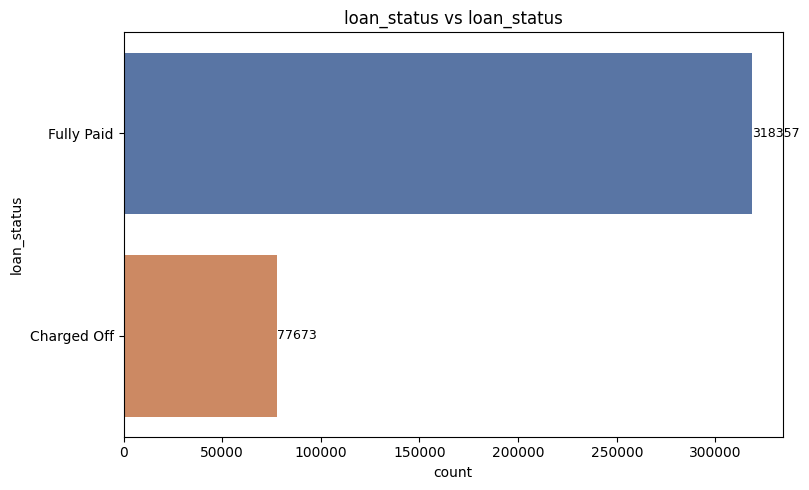

In [79]:
plot_categorical(df, ['loan_status'], figsize=(15,5))

- Very high Class imbalance exists in our dataset

As class is imbalanced we will use class_weight="balanced" in logistic regression model to give equal importance to minority classes.

Here we can't use accuracy or roc_auc because of imbalance, so we will rely on
- PR AUC
- Recall, Precision, Fbeta score
- MCC

mapping :

`1 -> Charged off or Default`

`0 -> Fully paid or No-Default`

In [80]:
df["loan_status"] = df["loan_status"].map({
    "Charged Off": 1,
    "Fully Paid": 0
})

In [81]:
df.loan_status.value_counts(normalize=True)*100

loan_status
0    80.387092
1    19.612908
Name: proportion, dtype: float64

##`14. purpose`

In [82]:
null_summary(df, ['purpose'])

null_count  null_percent
purpose           0           0.0

In [83]:
df['purpose'].value_counts(dropna= False)

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: count, dtype: int64

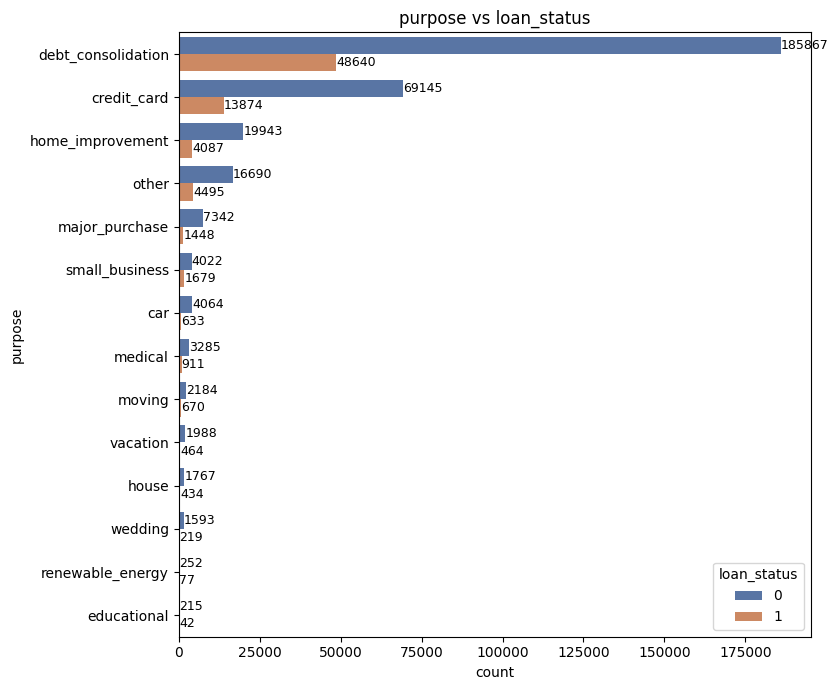

In [84]:
plot_categorical(df, ['purpose'], figsize=(15,7))

As the purpose is nominal feature, it will be ohe.

In [85]:
ohe_cols.append('purpose')

##`15. title`

This column is not needed as it is almost same as purpose` col, so will drop this one.

In [86]:
drop_cols.append('title')

##`16. dti`

In [87]:
null_summary(df, ['dti'])

null_count  null_percent
dti           0           0.0

Statistics for dti:
  Mean   : 17.38
  Median : 16.91
  Std Dev: 18.02
  Min    : 0.00
  Max    : 9999.00


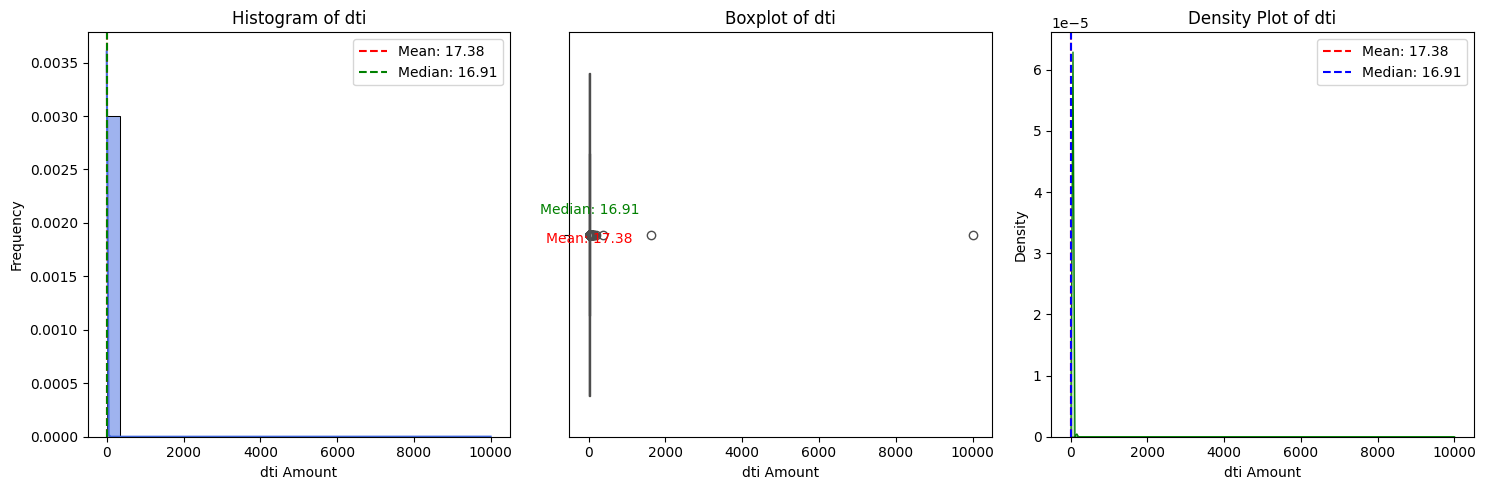

In [88]:
numerical_columns_distribution_with_stats(df, ['dti'])

In [89]:
iqr_outliers_boxplot(df, cols = ['dti'])


Column: dti
Below lower bound -6.270000000000001 : 0 (0.00%)
Above upper bound 40.53 : 275 (0.07%)
Total outliers    : 275 (0.07%)


will Robust scale this column

In [90]:
robust_cols.append('dti')

##`17. earliest_cr_line`

In [91]:
null_summary(df, ['earliest_cr_line'])

null_count  null_percent
earliest_cr_line           0           0.0

In [92]:
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format = '%b-%Y')

Longer credit history = usually safer borrower.

##`18. open_acc`

In [93]:
null_summary(df, ['open_acc'])

null_count  null_percent
open_acc           0           0.0

In [94]:
df['open_acc'].describe()

count    396030.000000
mean         11.311153
std           5.137649
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

Statistics for open_acc:
  Mean   : 11.31
  Median : 10.00
  Std Dev: 5.14
  Min    : 0.00
  Max    : 90.00


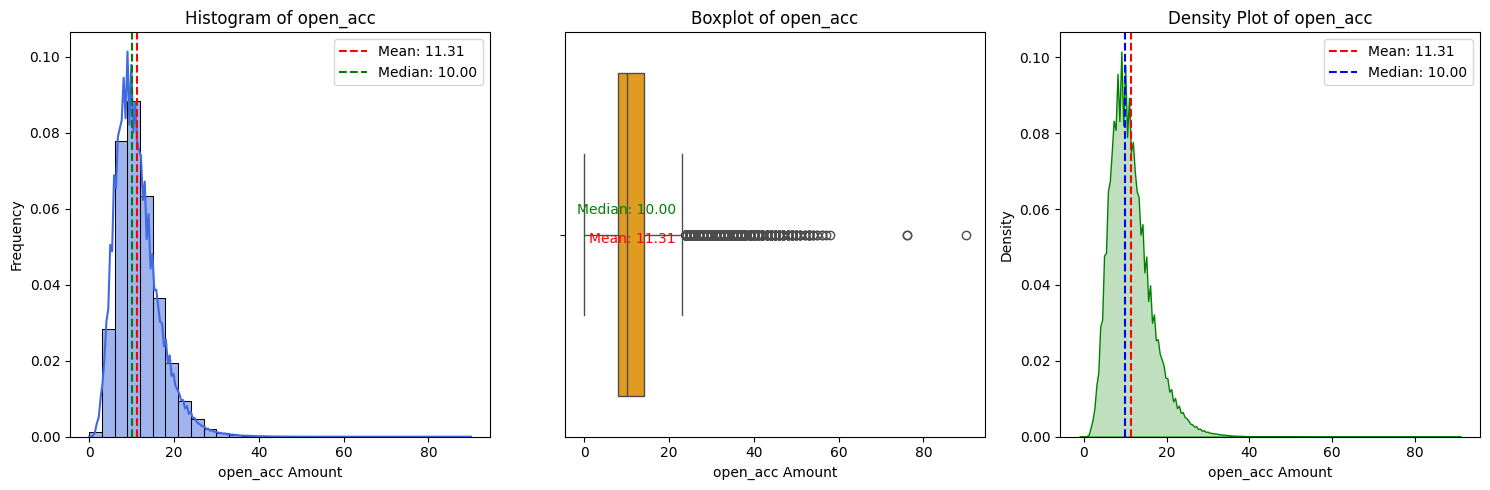

In [95]:
numerical_columns_distribution_with_stats(df, ['open_acc'])

In [96]:
iqr_outliers_boxplot(df, cols = ['open_acc'])


Column: open_acc
Below lower bound -1.0 : 0 (0.00%)
Above upper bound 23.0 : 10307 (2.60%)
Total outliers    : 10307 (2.60%)


In [97]:
df['open_acc'].skew()

np.float64(1.2130188444585455)

will Robust scale this col

In [98]:
robust_cols.append('open_acc')

##`19. pub_rec`

In [99]:
null_summary(df, ['pub_rec'])

null_count  null_percent
pub_rec           0           0.0

In [100]:
df['pub_rec'].describe()

count    396030.000000
mean          0.178191
std           0.530671
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [101]:
df['pub_rec'].value_counts(dropna= False)

pub_rec
0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: count, dtype: int64

/tmp/ipython-input-3838528032.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_series = df[col].astype(object).fillna("Missing")


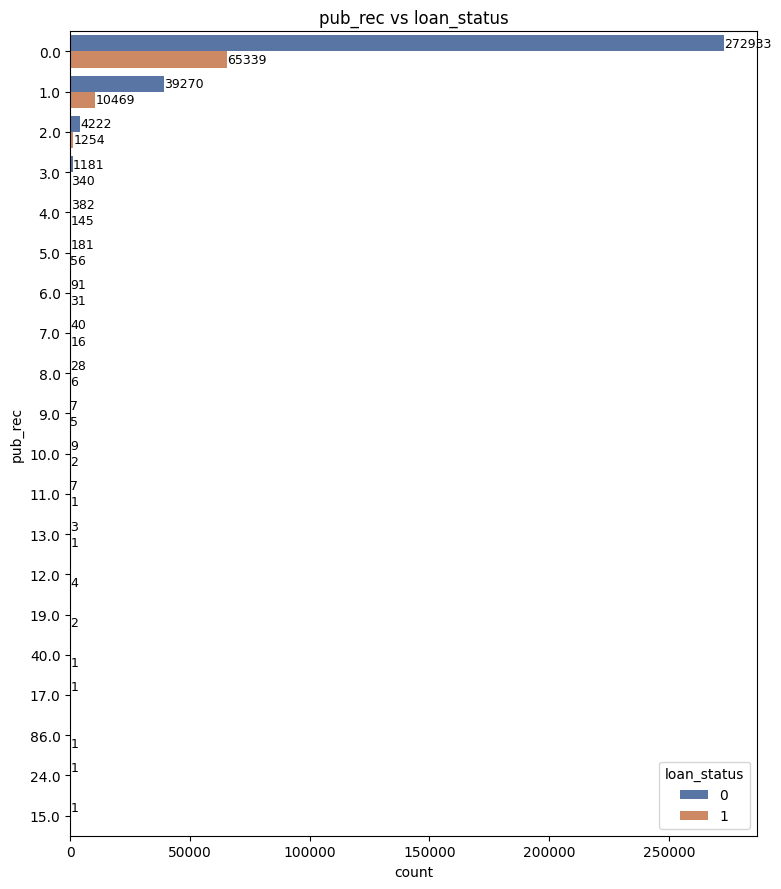

In [102]:
plot_categorical(df, ['pub_rec'], figsize=(15,9))

Statistics for pub_rec:
  Mean   : 0.18
  Median : 0.00
  Std Dev: 0.53
  Min    : 0.00
  Max    : 86.00


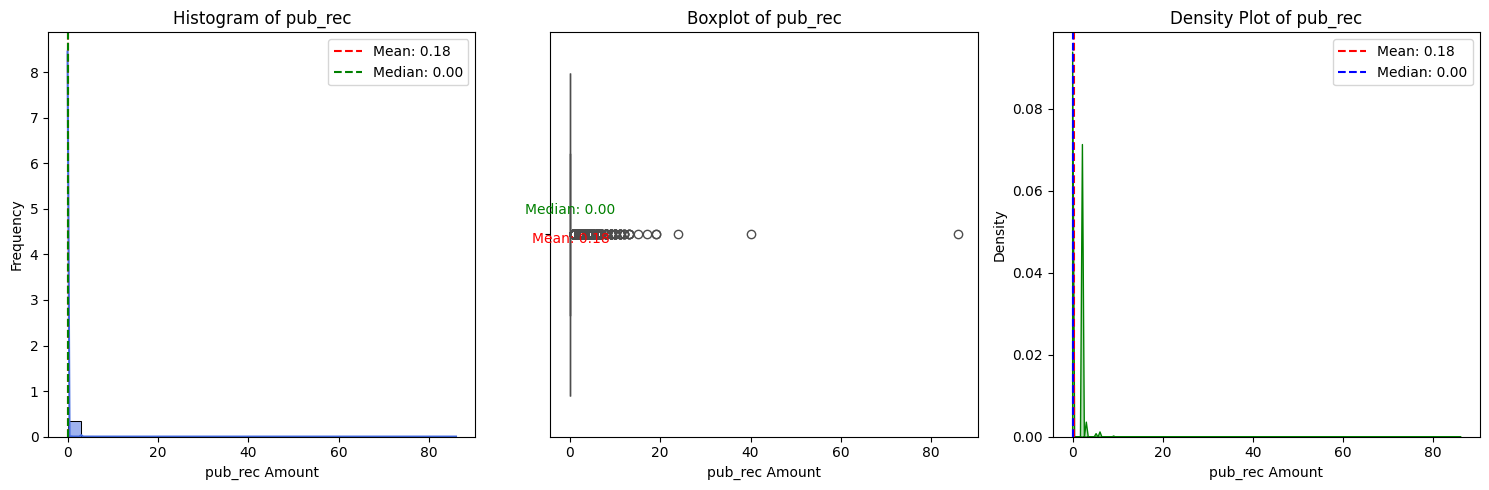

In [103]:
numerical_columns_distribution_with_stats(df, ['pub_rec'])

In [104]:
iqr_outliers_boxplot(df, cols = ['pub_rec'])


Column: pub_rec
Below lower bound 0.0 : 0 (0.00%)
Above upper bound 0.0 : 57758 (14.58%)
Total outliers    : 57758 (14.58%)


In [105]:
df['pub_rec'].skew()

np.float64(16.576564199464457)

will Robust scale this col

In [106]:
robust_cols.append('pub_rec')

In [107]:
binary_flag_col.append('pub_rec')

##`20. revol_bal`

In [108]:
null_summary(df, ['revol_bal'])

null_count  null_percent
revol_bal           0           0.0

Statistics for revol_bal:
  Mean   : 15844.54
  Median : 11181.00
  Std Dev: 20591.84
  Min    : 0.00
  Max    : 1743266.00


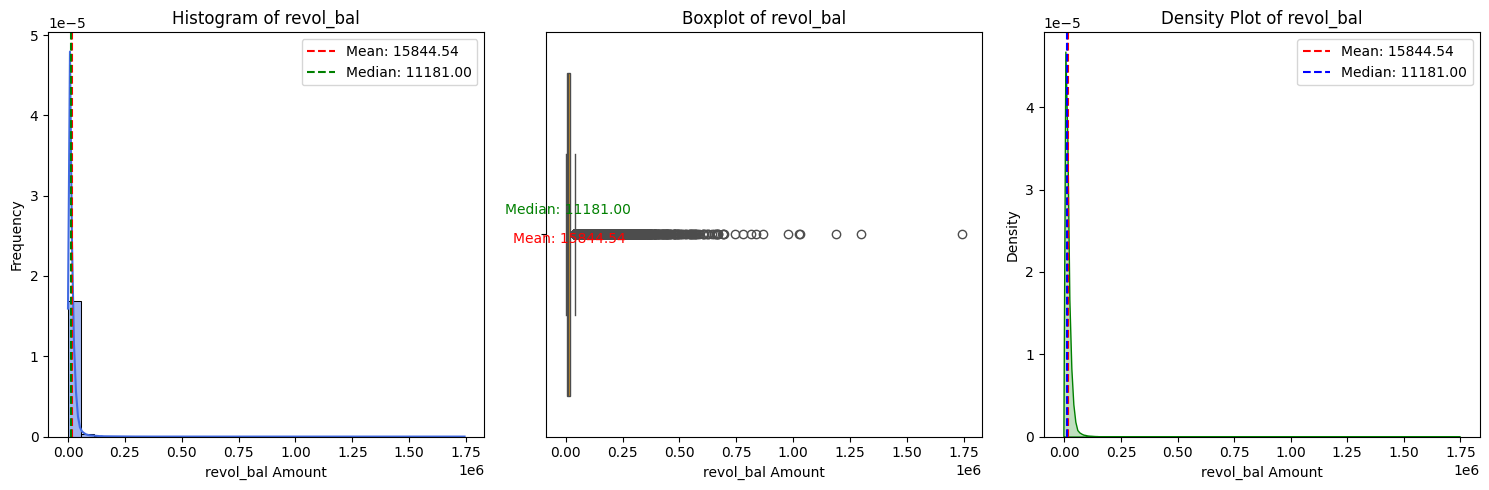

In [109]:
numerical_columns_distribution_with_stats(df, ['revol_bal'])

In [110]:
iqr_outliers_boxplot(df, cols = ['revol_bal'])


Column: revol_bal
Below lower bound -14367.5 : 0 (0.00%)
Above upper bound 40012.5 : 21259 (5.37%)
Total outliers    : 21259 (5.37%)


In [111]:
df['revol_bal'].skew()

np.float64(11.727515124126919)

will Robust scale

In [112]:
robust_cols.append('revol_bal')

##`21. revol_util`

In [113]:
null_summary(df, ['revol_util'])

null_count  null_percent
revol_util         276          0.07

In [114]:
df['revol_util'].describe()

count    395754.000000
mean         53.791749
std          24.452193
min           0.000000
25%          35.800000
50%          54.800000
75%          72.900000
max         892.300000
Name: revol_util, dtype: float64

Statistics for revol_util:
  Mean   : 53.79
  Median : 54.80
  Std Dev: 24.45
  Min    : 0.00
  Max    : 892.30


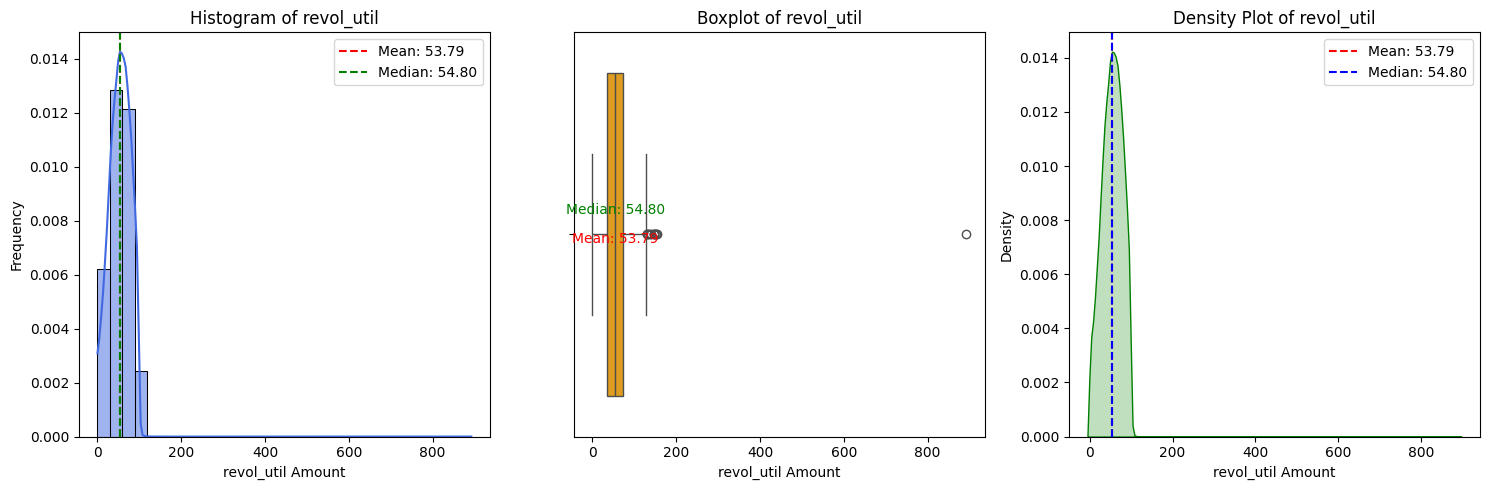

In [115]:
numerical_columns_distribution_with_stats(df, ['revol_util'])

In [116]:
iqr_outliers_boxplot(df, cols = ['revol_util'])


Column: revol_util
Below lower bound -19.850000000000016 : 0 (0.00%)
Above upper bound 128.55 : 12 (0.00%)
Total outliers    : 12 (0.00%)


In [117]:
df['revol_util'].skew()

np.float64(-0.07177802032853098)

will median impute null and then standard scale this col

In [118]:
null_std_cols.append('revol_util')

##`22. total_acc`

In [119]:
null_summary(df, ['total_acc'])

null_count  null_percent
total_acc           0           0.0

In [120]:
df['total_acc'].describe()

count    396030.000000
mean         25.414744
std          11.886991
min           2.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         151.000000
Name: total_acc, dtype: float64

Statistics for total_acc:
  Mean   : 25.41
  Median : 24.00
  Std Dev: 11.89
  Min    : 2.00
  Max    : 151.00


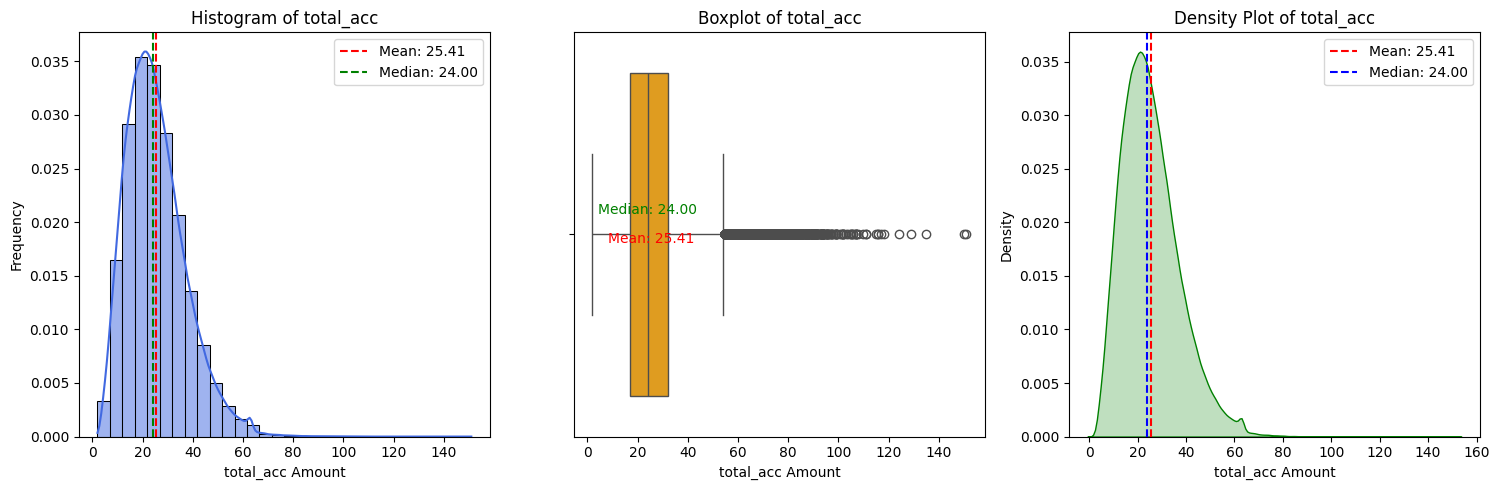

In [121]:
numerical_columns_distribution_with_stats(df, ['total_acc'])

In [122]:
iqr_outliers_boxplot(df, cols = ['total_acc'])


Column: total_acc
Below lower bound -5.5 : 0 (0.00%)
Above upper bound 54.5 : 8499 (2.15%)
Total outliers    : 8499 (2.15%)


In [123]:
df['total_acc'].skew()

np.float64(0.8643276369429)

will Robust scale this col

In [124]:
robust_cols.append('total_acc')

##`23. initial_list_status`

In [125]:
null_summary(df, ['initial_list_status'])

null_count  null_percent
initial_list_status           0           0.0

In [126]:
df['initial_list_status'].value_counts(dropna= False)

initial_list_status
f    238066
w    157964
Name: count, dtype: int64

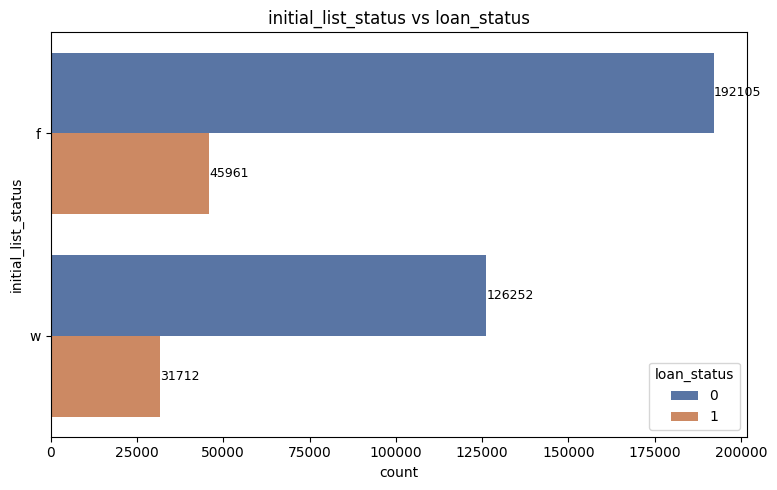

In [127]:
plot_categorical(df, ['initial_list_status'], figsize=(15,5))

will ohe this col

In [128]:
ohe_cols.append('initial_list_status')

##`24. application_type`

In [129]:
null_summary(df, ['application_type'])

null_count  null_percent
application_type           0           0.0

In [130]:
df['application_type'].value_counts(dropna= False)

application_type
INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: count, dtype: int64

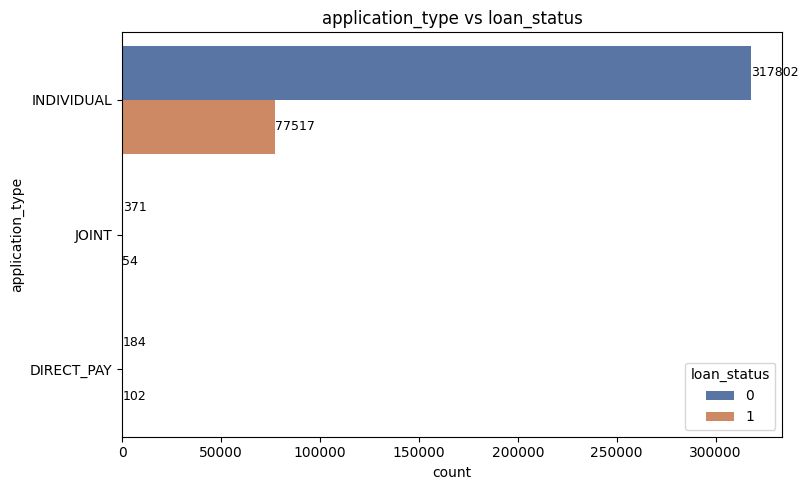

In [131]:
plot_categorical(df, ['application_type'], figsize=(15,5))

will ohe this col

In [132]:
ohe_cols.append('application_type')

##`25. mort_acc`

In [133]:
null_summary(df, ['mort_acc'])

null_count  null_percent
mort_acc       37795          9.54

In [134]:
df['mort_acc'].describe()

count    358235.000000
mean          1.813991
std           2.147930
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          34.000000
Name: mort_acc, dtype: float64

Statistics for mort_acc:
  Mean   : 1.81
  Median : 1.00
  Std Dev: 2.15
  Min    : 0.00
  Max    : 34.00


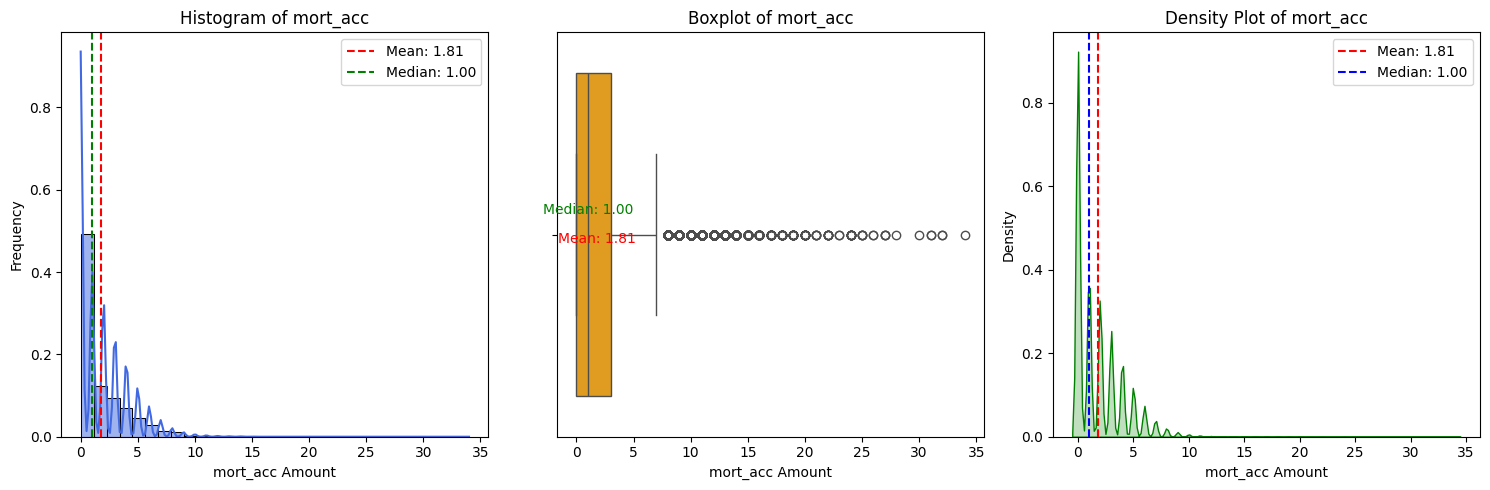

In [135]:
numerical_columns_distribution_with_stats(df, ['mort_acc'])

In [136]:
iqr_outliers_boxplot(df, cols = ['mort_acc'])


Column: mort_acc
Below lower bound -4.5 : 0 (0.00%)
Above upper bound 7.5 : 6843 (1.73%)
Total outliers    : 6843 (1.73%)


In [137]:
df.mort_acc.skew()

np.float64(1.6001324380874855)

In [138]:
df.mort_acc.value_counts(dropna= False)

mort_acc
0.0     139777
1.0      60416
2.0      49948
3.0      38049
NaN      37795
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
26.0         2
32.0         2
31.0         2
23.0         2
34.0         1
28.0         1
30.0         1
Name: count, dtype: int64

will Median impute and then standard scale this col

In [139]:
null_std_cols.append('mort_acc')

In [140]:
binary_flag_col.append('mort_acc')

##`26. pub_rec_bankruptcies`

In [141]:
null_summary(df, ['pub_rec_bankruptcies'])

null_count  null_percent
pub_rec_bankruptcies         535          0.14

In [142]:
df['pub_rec_bankruptcies'].describe()

count    395495.000000
mean          0.121648
std           0.356174
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: pub_rec_bankruptcies, dtype: float64

In [143]:
df['pub_rec_bankruptcies'].value_counts(dropna= False)

pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
NaN       535
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64

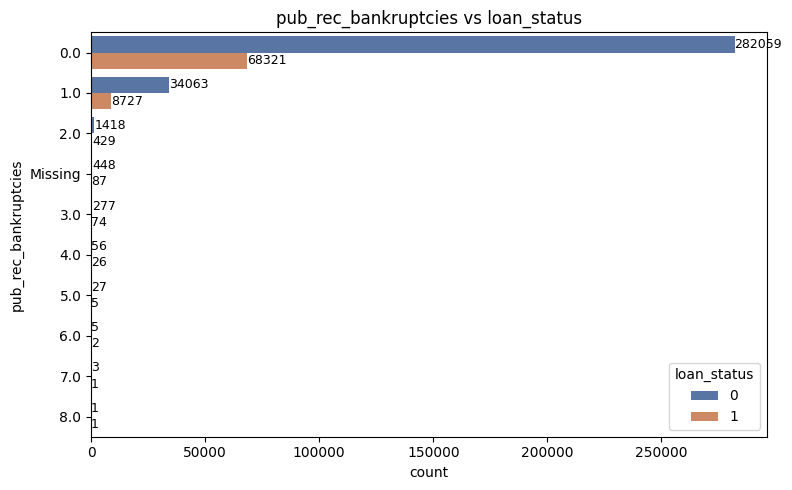

In [144]:
plot_categorical(df, ['pub_rec_bankruptcies'], figsize=(15,5))

will impute null with median then standard scale

In [145]:
null_std_cols.append('pub_rec_bankruptcies')

In [146]:
binary_flag_col.append('pub_rec_bankruptcies')

##`27. address`

In [147]:
null_summary(df, ['address'])

null_count  null_percent
address           0           0.0

In [148]:
pd.set_option('display.max_colwidth', None)

In [149]:
df['address'].str.split().str[-1].value_counts(dropna= False).reset_index()

address  count
0   70466  56985
1   30723  56546
2   22690  56527
3   48052  55917
4   00813  45824
5   29597  45471
6   05113  45402
7   11650  11226
8   93700  11151
9   86630  10981

In [150]:
temp = pd.concat((df['address'].str.split().str[-1], df['loan_status']), axis = 1)

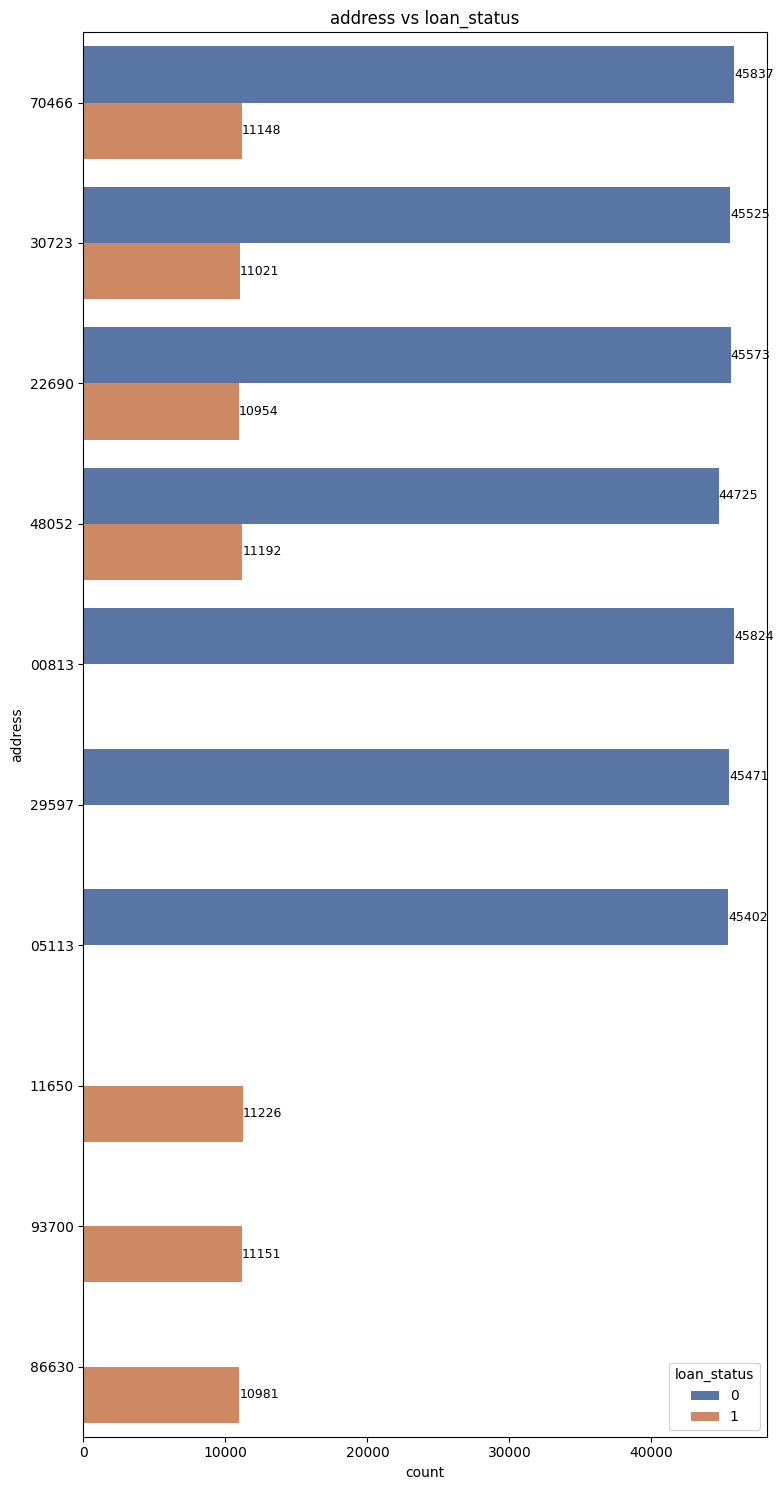

In [151]:
plot_categorical(temp, ['address'],show_nulls=False, figsize=(15,15))

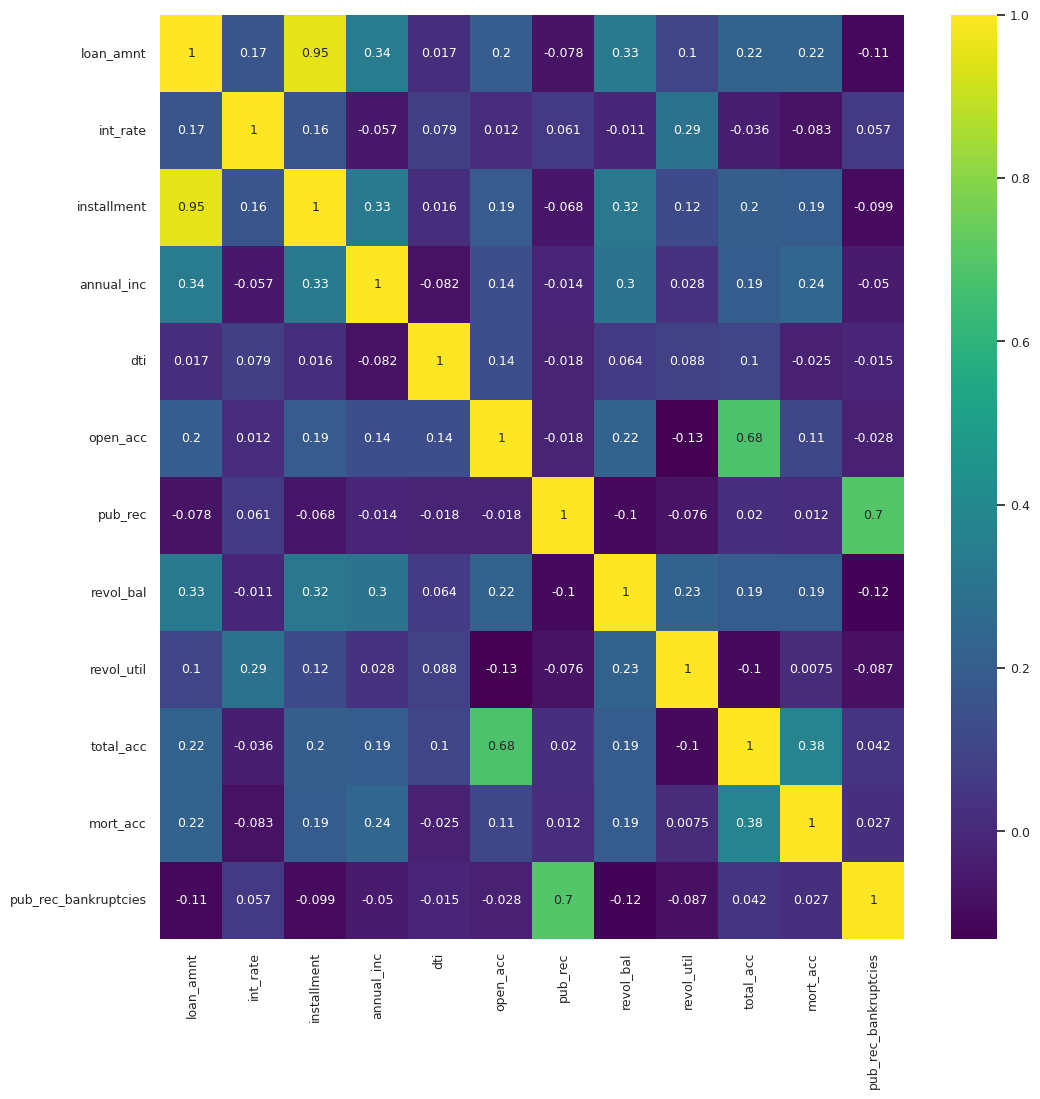

In [236]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.select_dtypes(include=['int','float']).corr(), annot=True, cmap = 'viridis', fmt = ".2g")
plt.show()

In [152]:
cat_cols = [
    "term",
    "grade",
    "emp_length",
    "home_ownership",
    "verification_status",
    "loan_status",
    "purpose",
    "initial_list_status",
    "application_type"
]

df[cat_cols] = df[cat_cols].astype("category")
df['issue_d'] = pd.to_datetime(df['issue_d'], format = '%b-%Y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%Y')

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  category      
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  category      
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  category      
 8   home_ownership        396030 non-null  category      
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  category      
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  category      
 13 

In [154]:
print(drop_cols)
print(robust_cols)
print(null_std_cols)
print(ordinal_cols)
print(null_ordinal_cols)
print(ohe_cols)
print(binary_flag_col)

['installment', 'grade', 'emp_title', 'title']
['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']
['revol_util', 'mort_acc', 'pub_rec_bankruptcies']
{'sub_grade': ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']}
{'emp_length': ['Missing', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']}
['term', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']
['pub_rec', 'mort_acc', 'pub_rec_bankruptcies']


In [155]:
df_ = df_.drop(columns=drop_cols)

#Train-test-split

In [156]:
X = df_.drop(columns=["loan_status"])
y = df_["loan_status"]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Preprocessing

In [158]:
robust_cols

['loan_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc']

In [159]:
robust = RobustScaler()
X_train[robust_cols] = robust.fit_transform(X_train[robust_cols])
X_test[robust_cols] = robust.transform(X_test[robust_cols])

In [160]:
null_std_cols

['revol_util', 'mort_acc', 'pub_rec_bankruptcies']

In [161]:
for col in null_std_cols:
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)

scaler_null = StandardScaler()
X_train[null_std_cols] = scaler_null.fit_transform(X_train[null_std_cols])
X_test[null_std_cols] = scaler_null.transform(X_test[null_std_cols])

In [162]:
binary_flag_col

['pub_rec', 'mort_acc', 'pub_rec_bankruptcies']

In [163]:
flag_cols = ['pub_rec', 'mort_acc', 'pub_rec_bankruptcies']

for col in flag_cols:
    X_train[col + "_flag"] = (X_train[col].fillna(0) > 0).astype(int)
    X_test[col + "_flag"] = (X_test[col].fillna(0) > 0).astype(int)

In [164]:
print(ordinal_cols)

{'sub_grade': ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']}


In [165]:
for col, order in ordinal_cols.items():
    enc = OrdinalEncoder(categories=[order])
    X_train[[col]] = enc.fit_transform(X_train[[col]])
    X_test[[col]] = enc.transform(X_test[[col]])

In [166]:
print(emp_length_order)

['Missing', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']


In [167]:
X_train['emp_length'] = X_train['emp_length'].fillna('Missing')
X_test['emp_length'] = X_test['emp_length'].fillna('Missing')

enc_emp = OrdinalEncoder(categories=[emp_length_order])
X_train[['emp_length']] = enc_emp.fit_transform(X_train[['emp_length']])
X_test[['emp_length']] = enc_emp.transform(X_test[['emp_length']])

In [168]:
ohe_cols

['term',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [169]:
X_train = pd.get_dummies(X_train, columns=ohe_cols, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=ohe_cols, drop_first=True, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [170]:
X_train['zip'] = X_train['address'].str.split().str[-1]
X_test['zip'] = X_test['address'].str.split().str[-1]

X_train = pd.get_dummies(X_train, columns=['zip'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['zip'], drop_first=True, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train.drop(columns=['address'], inplace=True)
X_test.drop(columns=['address'], inplace=True)

In [171]:
X_train['issue_d'] = pd.to_datetime(X_train['issue_d'], format = '%b-%Y')
X_test['issue_d'] = pd.to_datetime(X_test['issue_d'], format = '%b-%Y')

# Extract month + year
X_train['issue_month'] = X_train['issue_d'].dt.month
X_test['issue_month'] = X_test['issue_d'].dt.month

X_train['issue_year'] = X_train['issue_d'].dt.year
X_test['issue_year'] = X_test['issue_d'].dt.year

X_train = pd.get_dummies(X_train, columns=['issue_month'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['issue_month'], drop_first=True, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler_year = StandardScaler()

X_train[['issue_year']] = scaler_year.fit_transform(
    X_train[['issue_year']]
)
X_test[['issue_year']] = scaler_year.transform(
    X_test[['issue_year']]
)


In [172]:
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line'], format = '%b-%Y')
X_test['earliest_cr_line'] = pd.to_datetime(X_test['earliest_cr_line'], format = '%b-%Y')

X_train['credit_age_years'] = (
    (X_train['issue_d'] - X_train['earliest_cr_line']).dt.days / 365
)

X_test['credit_age_years'] = (
    (X_test['issue_d'] - X_test['earliest_cr_line']).dt.days / 365
)

median_age = X_train['credit_age_years'].median()

X_train['credit_age_years'] = X_train['credit_age_years'].fillna(median_age)
X_test['credit_age_years'] = X_test['credit_age_years'].fillna(median_age)

scaler_age = StandardScaler()
X_train[['credit_age_years']] = scaler_age.fit_transform(
    X_train[['credit_age_years']]
)
X_test[['credit_age_years']] = scaler_age.transform(
    X_test[['credit_age_years']]
)

X_train.drop(columns=['issue_d','earliest_cr_line'], inplace=True)
X_test.drop(columns=['issue_d','earliest_cr_line'], inplace=True)


In [173]:
y_train = y_train.map({"Fully Paid": 0, "Charged Off": 1})
y_test = y_test.map({"Fully Paid": 0, "Charged Off": 1})

In [174]:
y_train.value_counts(normalize=True)

loan_status
0    0.803872
1    0.196128
Name: proportion, dtype: float64

In [175]:
y_test.value_counts(normalize=True)

loan_status
0    0.803866
1    0.196134
Name: proportion, dtype: float64

In [176]:
X_train.shape, X_test.shape

((316824, 62), (79206, 62))

#Using VIF to remove features having multicolinearity

In [177]:
def calc_vif(X_proc):
    vif = pd.DataFrame()
    vif['Features'] = X_proc.columns
    vif['VIF'] = [variance_inflation_factor(X_proc, i) for i in range(X_proc.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [178]:
vif = calc_vif(X_train)
vif

Features      VIF
38  application_type_INDIVIDUAL  1479.30
17      home_ownership_MORTGAGE   823.87
21          home_ownership_RENT   662.15
20           home_ownership_OWN   157.17
2                     sub_grade    87.98
..                          ...      ...
41                    zip_11650     1.26
61             credit_age_years     1.23
18          home_ownership_NONE     1.10
33     purpose_renewable_energy     1.07
26          purpose_educational     1.06

[62 rows x 2 columns]

In [179]:
vif_thr = 5
cols2 = vif["Features"][1:].values
i = 1
feats_removed = ['application_type_INDIVIDUAL']
while True:
  vif = calc_vif(X_train[cols2])
  print('='*20)
  print(vif.head(10))
  print('='*20)
  cols2 = vif["Features"][1:].values

  if (vif.iloc[0]['VIF'] < vif_thr):
    print('Reached threshold')
    print('Highest vif:',vif.iloc[0])
    print('Features removed:', i)
    print('List of features removed:', feats_removed)
    break
  feats_removed.append(vif.iloc[0]['Features'])
  i += 1

                     Features    VIF
3                   sub_grade  87.98
0     home_ownership_MORTGAGE  87.89
1         home_ownership_RENT  69.88
4  purpose_debt_consolidation  51.84
5                    int_rate  22.28
6         purpose_credit_card  19.04
7   pub_rec_bankruptcies_flag  17.85
2          home_ownership_OWN  17.28
8        pub_rec_bankruptcies  12.08
9                pub_rec_flag   8.40
                      Features    VIF
0      home_ownership_MORTGAGE  57.41
2   purpose_debt_consolidation  51.82
1          home_ownership_RENT  45.49
4          purpose_credit_card  19.02
5    pub_rec_bankruptcies_flag  17.84
7         pub_rec_bankruptcies  12.08
6           home_ownership_OWN  11.49
8                 pub_rec_flag   8.39
9     purpose_home_improvement   6.19
10               purpose_other   5.56
                      Features    VIF
3    pub_rec_bankruptcies_flag  17.68
0   purpose_debt_consolidation  14.40
4         pub_rec_bankruptcies  11.92
6                 pub_r

In [180]:
feats_removed

['application_type_INDIVIDUAL',
 'sub_grade',
 'home_ownership_MORTGAGE',
 'pub_rec_bankruptcies_flag',
 'purpose_debt_consolidation',
 'pub_rec_flag']

In [181]:
X_train.drop(columns=feats_removed, inplace=True)
X_test.drop(columns=feats_removed, inplace=True)

#Model training & evaluation

In [182]:
X_train.shape, X_test.shape

((316824, 56), (79206, 56))

In [183]:
df_.loan_status.value_counts(),318357/77673

(loan_status
 Fully Paid     318357
 Charged Off     77673
 Name: count, dtype: int64,
 4.098682940017767)

In [184]:
model = LogisticRegression(solver = 'lbfgs', max_iter=1000, class_weight={0: 1, 1: 4})

In [186]:
model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 4}, max_iter=1000)

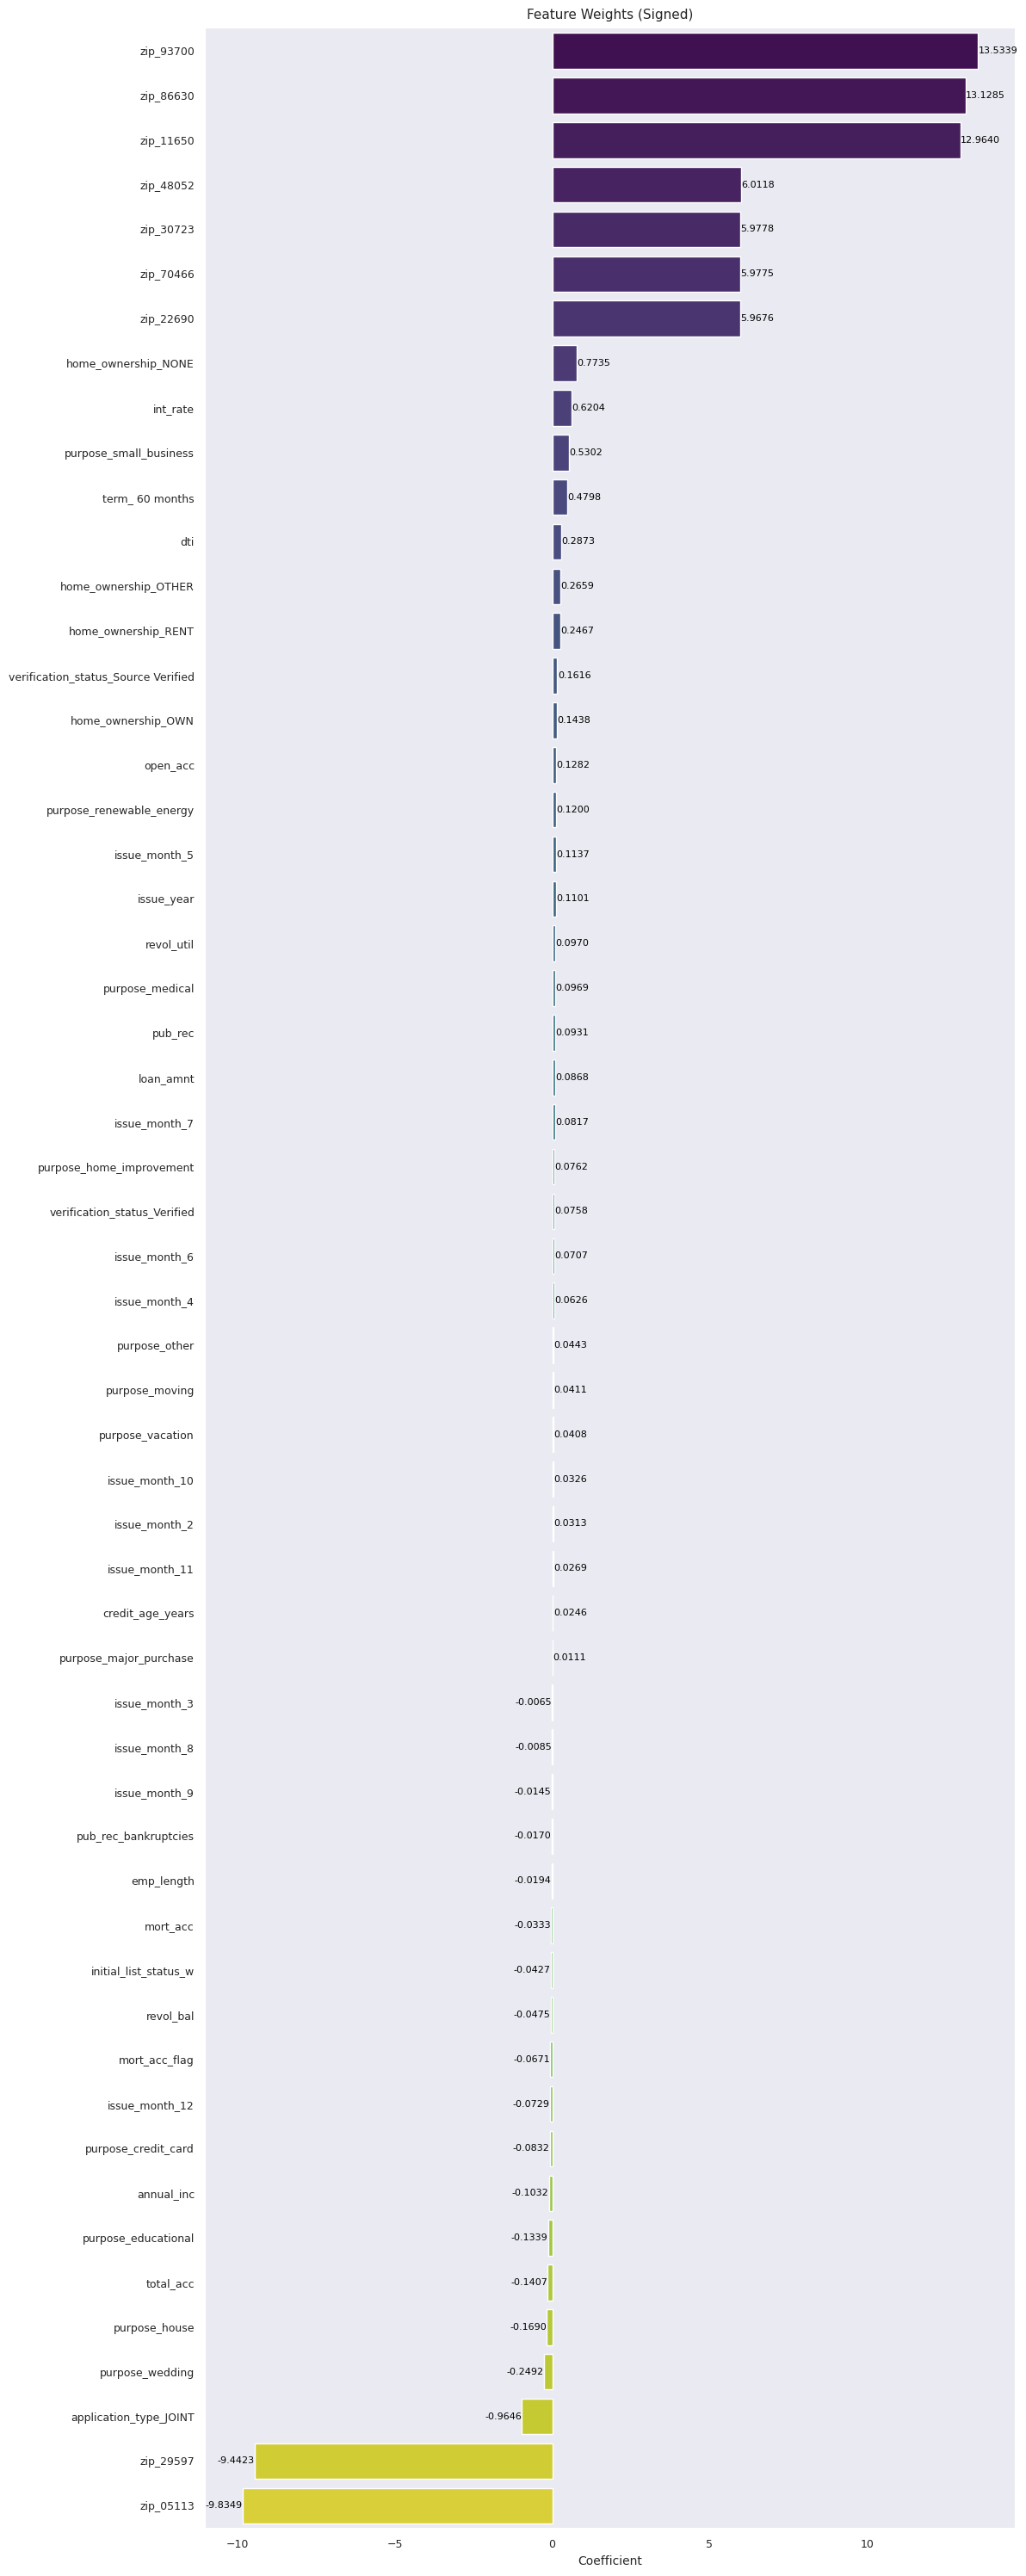

In [187]:
plot_model_weights(model_weights(model, X = X_train), fig_size=(12,30))


Classification Report

              precision    recall  f1-score   support

           0       0.94      0.82      0.87    254686
           1       0.51      0.79      0.62     62138

    accuracy                           0.81    316824
   macro avg       0.73      0.80      0.75    316824
weighted avg       0.86      0.81      0.82    316824



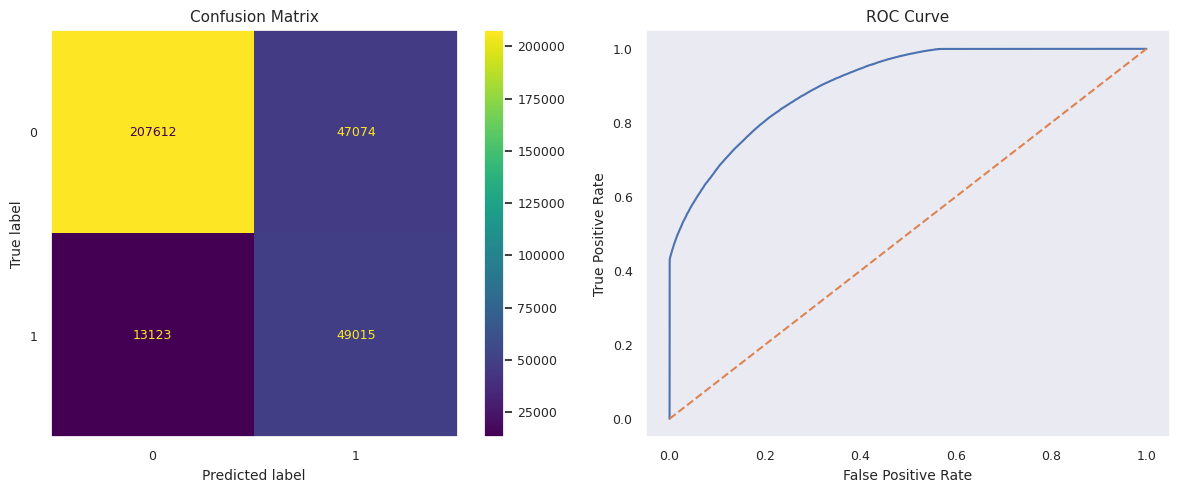

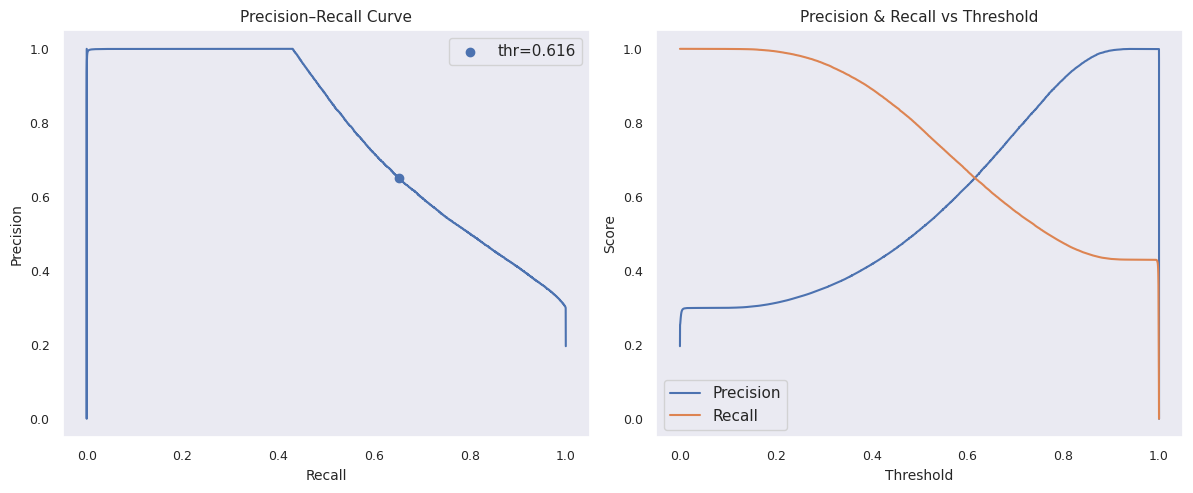

accuracy: 0.809998611216322
precision: 0.5101000114477203
recall (TPR): 0.7888087804564035
f1_score: 0.6195529208036555
mcc: 0.5217101951625536
TPR: 0.7888087804564035
TNR: 0.8151684819738816
FPR: 0.18483151802611844
FNR: 0.21119121954359651
TP: 49015
TN: 207612
FP: 47074
FN: 13123
roc_auc: 0.9051853664870583
pr_auc: 0.776285239127358


In [188]:
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
evaluate_classifier(y_train, y_pred_train, y_prob=y_pred_proba_train)


Classification Report

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     63671
           1       0.51      0.79      0.62     15535

    accuracy                           0.81     79206
   macro avg       0.73      0.80      0.75     79206
weighted avg       0.86      0.81      0.82     79206



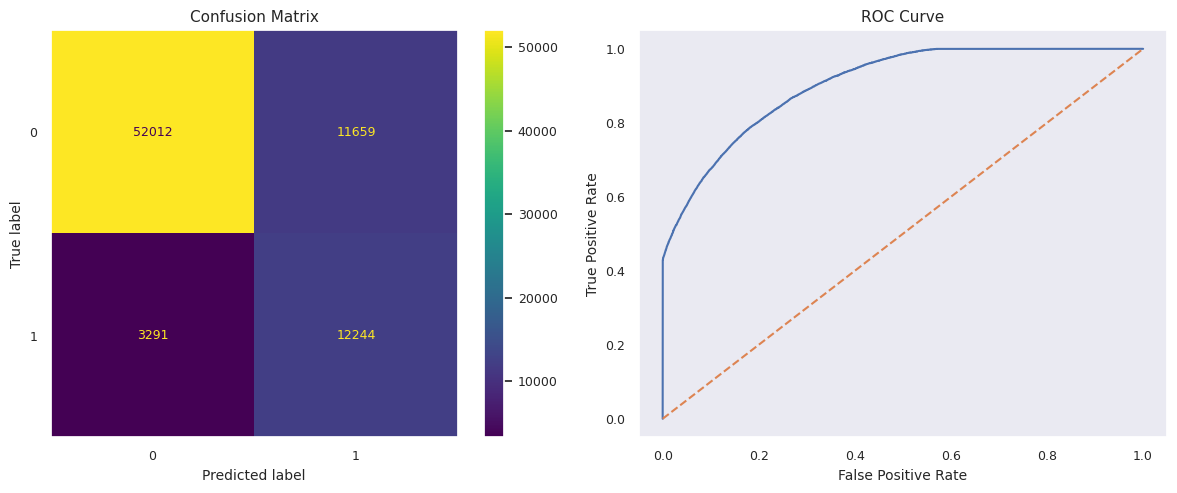

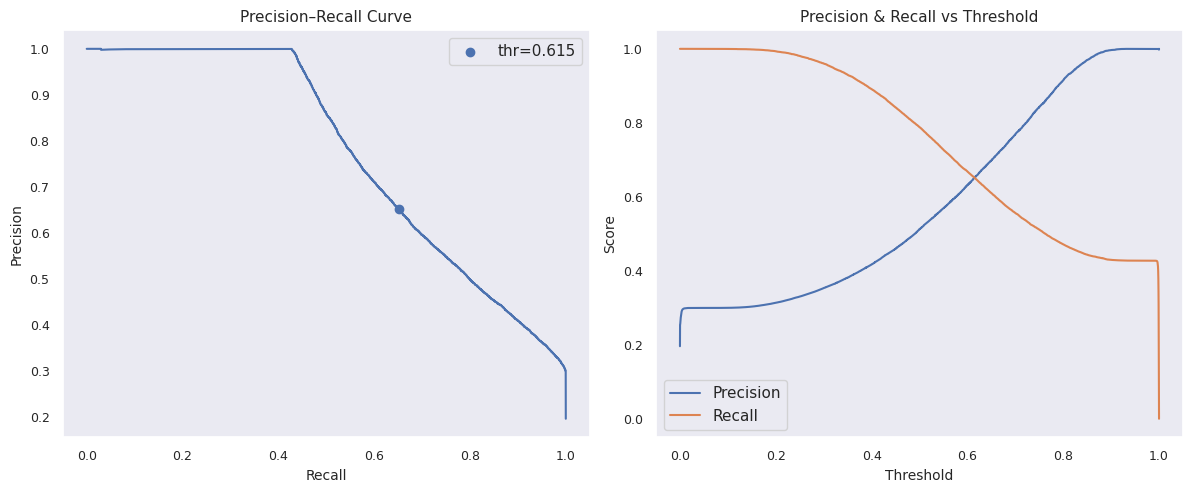

accuracy: 0.8112516728530667
precision: 0.5122369577040539
recall (TPR): 0.7881557772771162
f1_score: 0.6209239819463461
mcc: 0.5233736535527399
TPR: 0.7881557772771162
TNR: 0.8168868087512369
FPR: 0.18311319124876319
FNR: 0.2118442227228838
TP: 12244
TN: 52012
FP: 11659
FN: 3291
roc_auc: 0.9047979834500554
pr_auc: 0.7743435007004658


In [189]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
evaluate_classifier(y_test, y_pred, y_prob=y_pred_proba)

### Key Performance Metrics

- **Accuracy:** 81% of loans classified correctly.
- **Default Detection:** 79% of defaulters correctly identified.
- **Good Loan Approval:** 82% of safe borrowers correctly approved.
- **ROC AUC:** 0.90, indicating strong separation between risky and safe borrowers.
- **PR AUC:** 0.77, showing good performance under class imbalance.

---

### Business Interpretation

- Majority of risky borrowers are correctly identified, reducing credit losses.
- Most safe customers are approved, supporting business growth.
- Some safe customers are rejected and some risky borrowers still pass approvals, indicating room for threshold optimization.

---

### Error Impact Summary

- 12K risky loans correctly detected, preventing losses.
- 3K risky loans missed, creating residual credit risk.
- 52K safe loans correctly approved, generating profit.
- 11K safe loans rejected, causing missed business opportunities.

---


As class imbalance exist, using `class_weight` and finding best `class_weight`

In [192]:
param_grid = {
    "class_weight": [
        {0:1, 1:2},
        {0:1, 1:3},
        {0:1, 1:4},
        {0:1, 1:5},
        {0:1, 1:6},
        {0:1, 1:7},
        {0:1, 1:8}
    ]
}

grid = GridSearchCV(
    model,
    param_grid,
    scoring="f1",   # or "roc_auc" or custom MCC scorer
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'class_weight': {0: 1, 1: 2}}


In [193]:
model = grid.best_estimator_

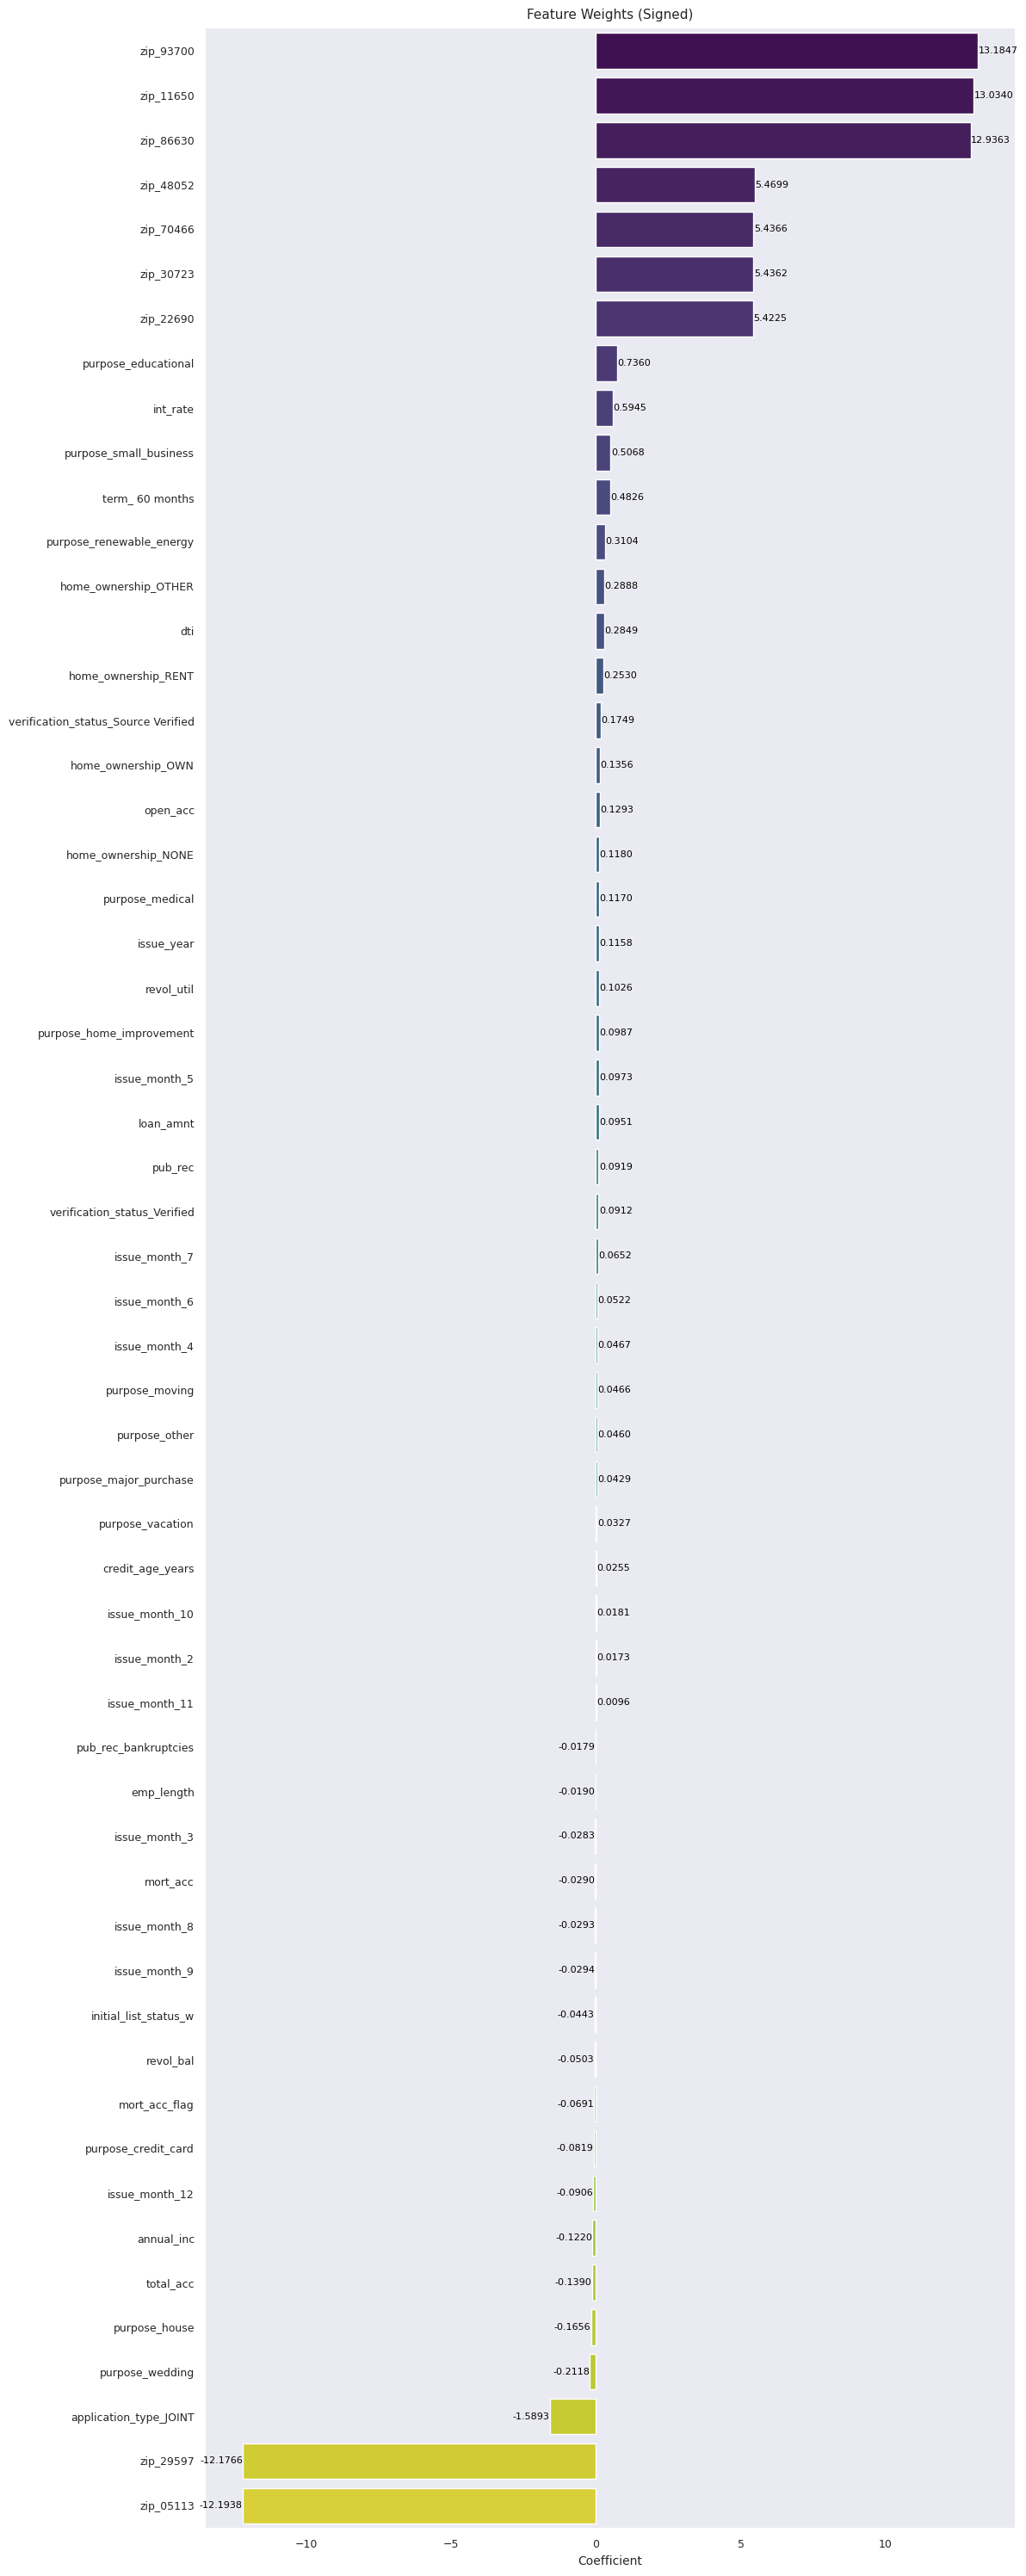

In [194]:
plot_model_weights(model_weights(model, X = X_train), fig_size=(12,30))


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     63671
           1       0.72      0.59      0.65     15535

    accuracy                           0.88     79206
   macro avg       0.81      0.77      0.79     79206
weighted avg       0.87      0.88      0.87     79206



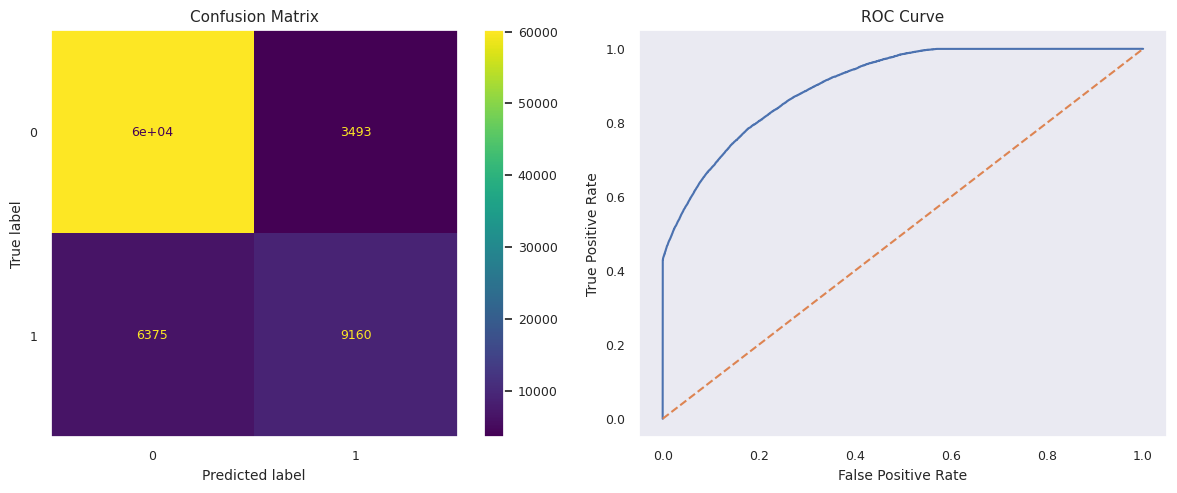

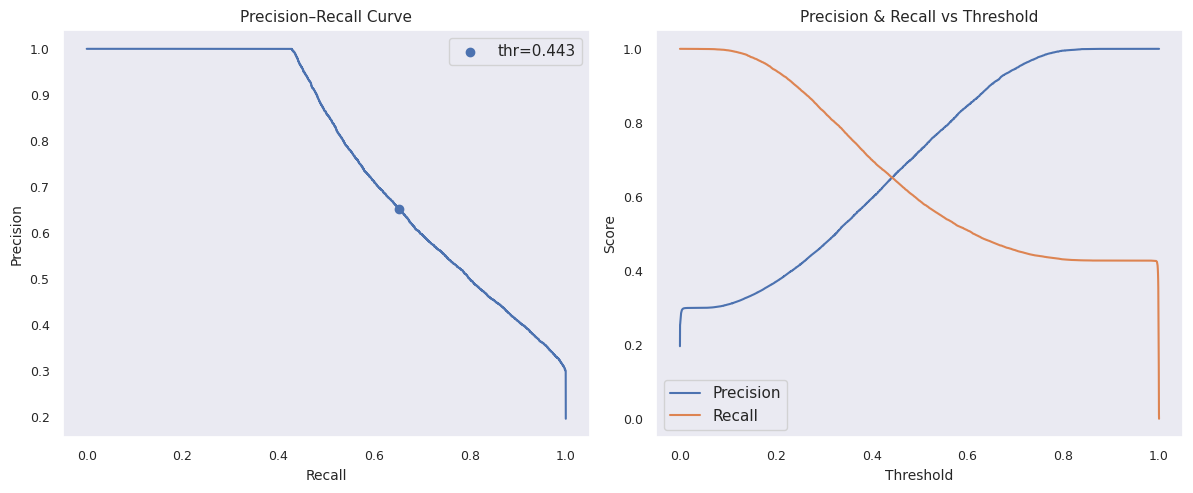

accuracy: 0.8754134787768604
precision: 0.723938986801549
recall (TPR): 0.5896363051174767
f1_score: 0.6499219526039449
mcc: 0.5795860634460218
TPR: 0.5896363051174767
TNR: 0.9451398595907085
FPR: 0.05486014040929151
FNR: 0.41036369488252333
TP: 9160
TN: 60178
FP: 3493
FN: 6375
roc_auc: 0.9048095977088366
pr_auc: 0.7746547381147011


In [195]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
evaluate_classifier(y_test, y_pred, y_prob=y_pred_proba)

### Error Impact Summary

- **9,160** risky loans correctly detected, preventing potential credit losses.
- **6,375** risky loans missed, creating residual default risk in the portfolio.
- **60,178** safe loans correctly approved, generating portfolio revenue.
- **3,493** safe loans incorrectly rejected, leading to missed lending opportunities.


#Regularization

In [196]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(
    Cs=[0.001,0.01,0.1,0.5],
    penalty="l1",
    solver="liblinear",
    cv=3,          # automatically stratified
    scoring="f1",
    class_weight={0:1, 1:2},
    max_iter=1500,
    n_jobs=-1,
    random_state=42
)

In [197]:
X_small, _, y_small, _ = train_test_split(
    X_train,
    y_train,
    train_size=100000,   # sample size
    stratify=y_train,
    random_state=42
)

In [198]:
model.fit(X_small, y_small)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 0.5], class_weight={0: 1, 1: 2},
                     cv=3, max_iter=1500, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='f1', solver='liblinear')

In [199]:
model.C_

array([0.1])

In [200]:
model = LogisticRegression(
    C=0.1,
    penalty="l1",
    solver="liblinear",
    class_weight={0:1, 1:2},
    max_iter=1500
)

In [201]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 2}, max_iter=1500,
                   penalty='l1', solver='liblinear')

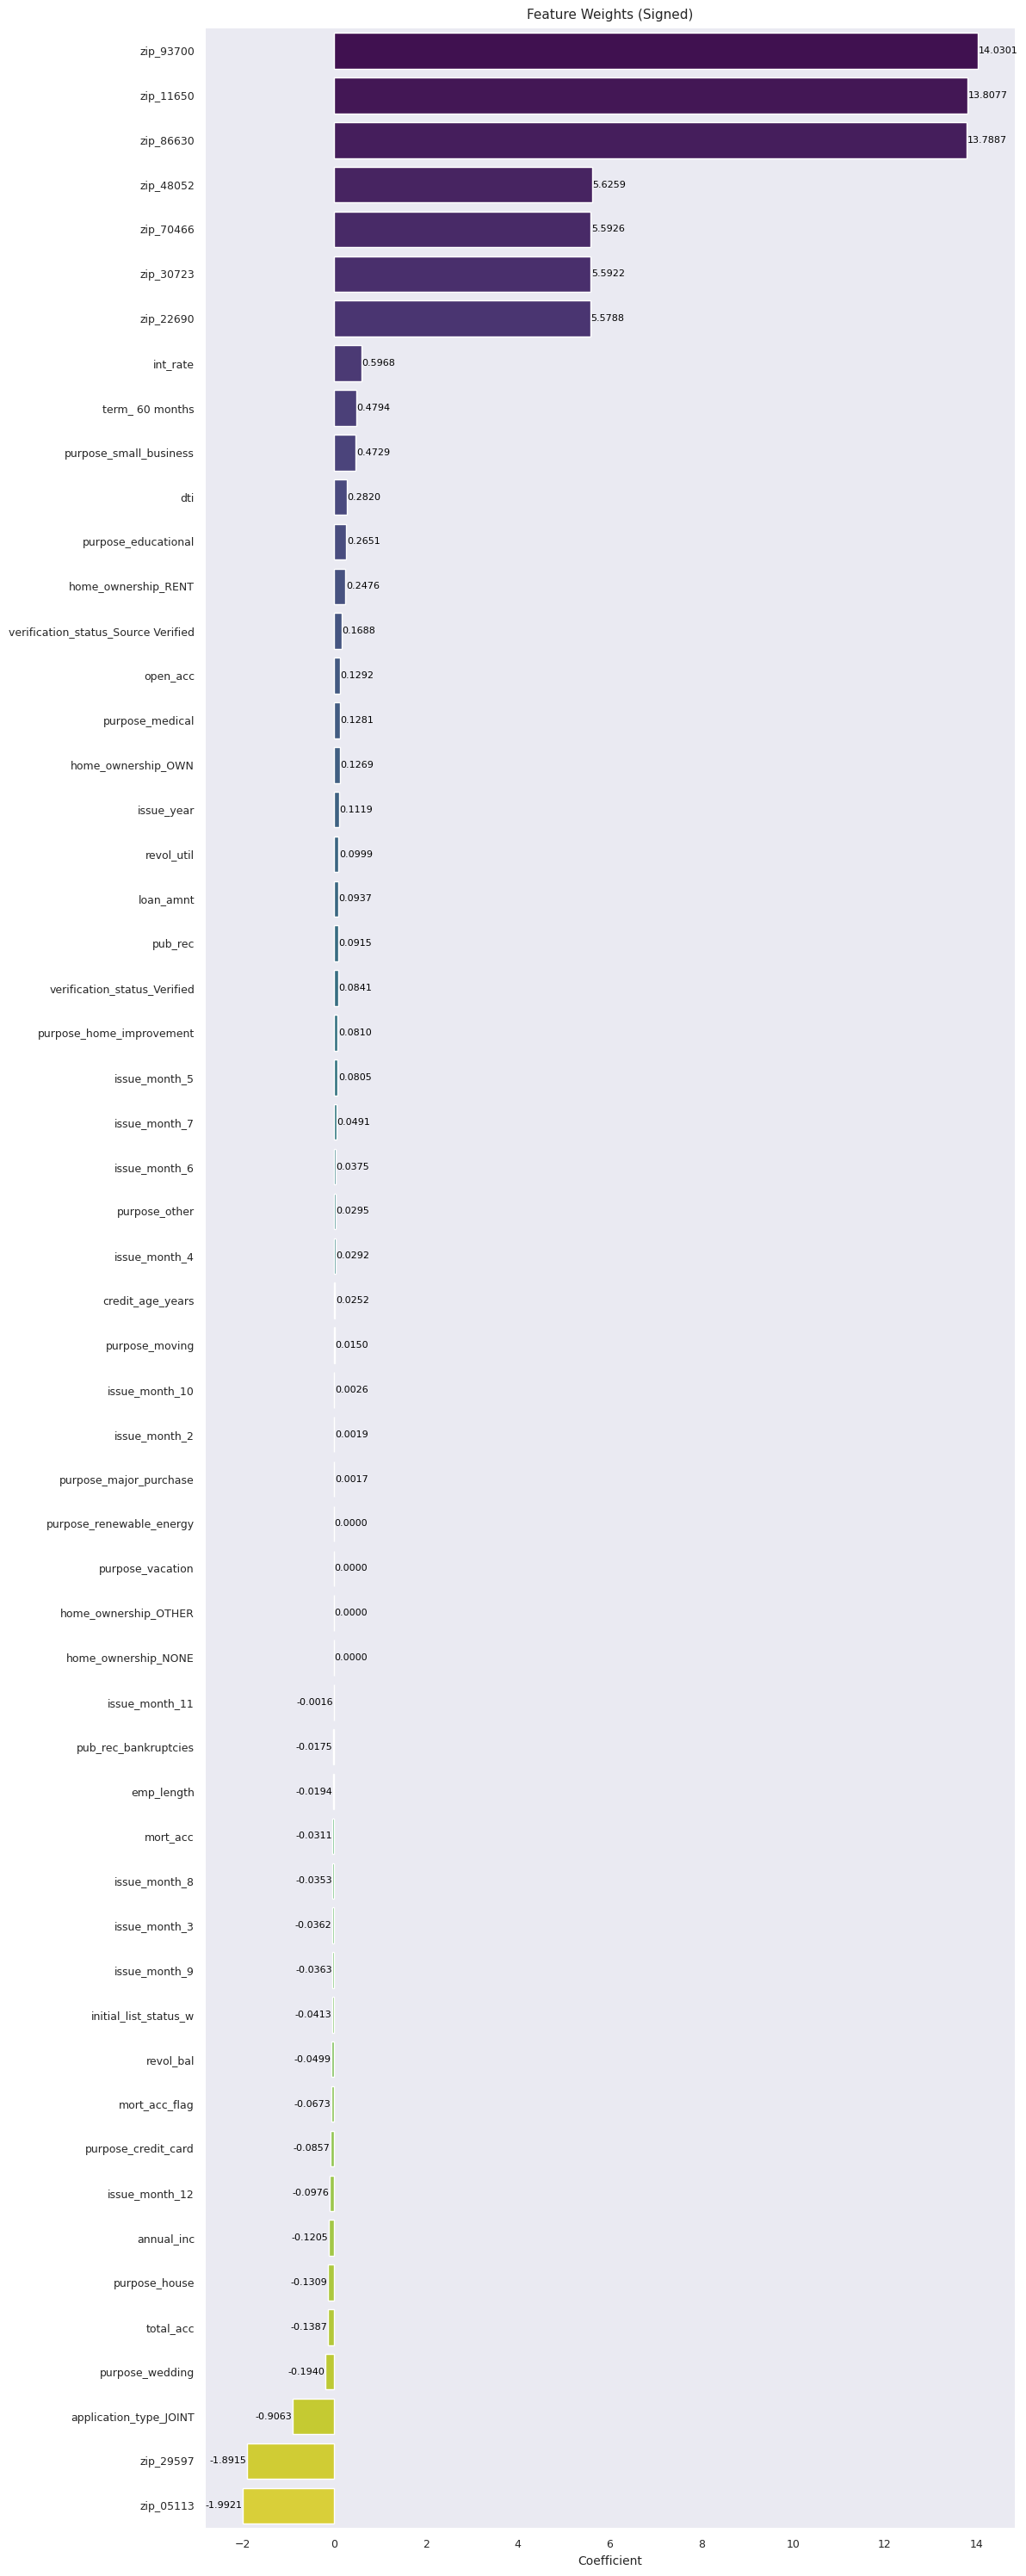

In [202]:
plot_model_weights(model_weights(model, X = X_train), fig_size=(12,30))


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92    254686
           1       0.73      0.59      0.65     62138

    accuracy                           0.88    316824
   macro avg       0.82      0.77      0.79    316824
weighted avg       0.87      0.88      0.87    316824



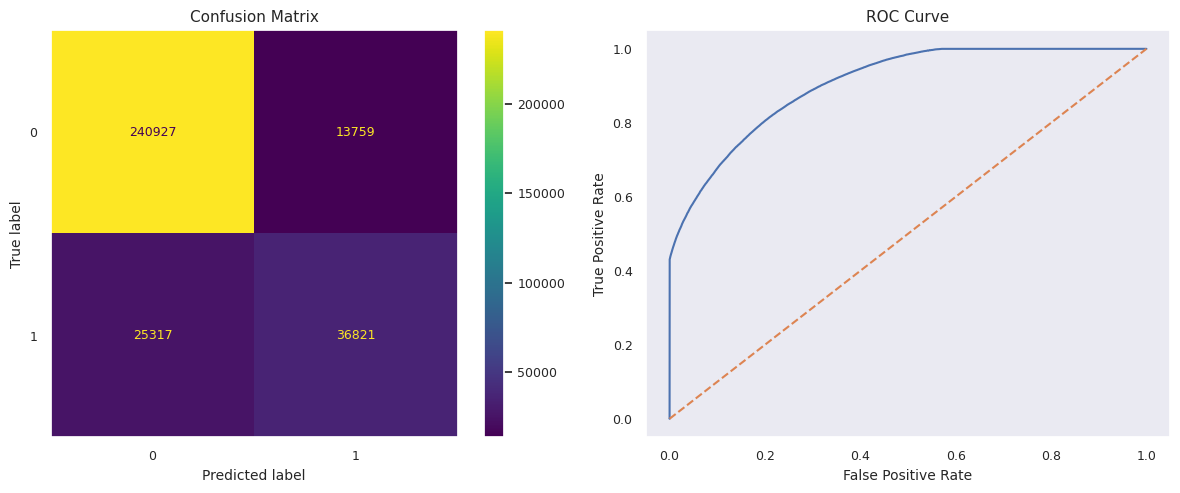

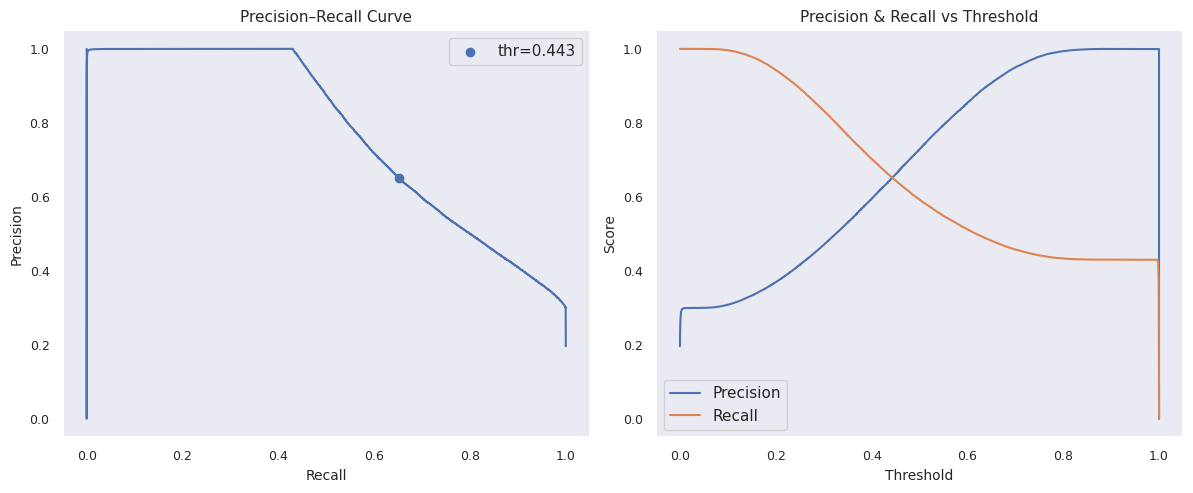

accuracy: 0.8766633840870641
precision: 0.7279754843811783
recall (TPR): 0.5925681547523255
f1_score: 0.6533295480757288
mcc: 0.5838128588836407
TPR: 0.5925681547523255
TNR: 0.9459766143407962
FPR: 0.05402338565920388
FNR: 0.4074318452476745
TP: 36821
TN: 240927
FP: 13759
FN: 25317
roc_auc: 0.9052305686559514
pr_auc: 0.7765227750166935


In [203]:
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
evaluate_classifier(y_train, y_pred_train, y_prob=y_pred_proba_train)


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     63671
           1       0.72      0.59      0.65     15535

    accuracy                           0.88     79206
   macro avg       0.81      0.77      0.79     79206
weighted avg       0.87      0.88      0.87     79206



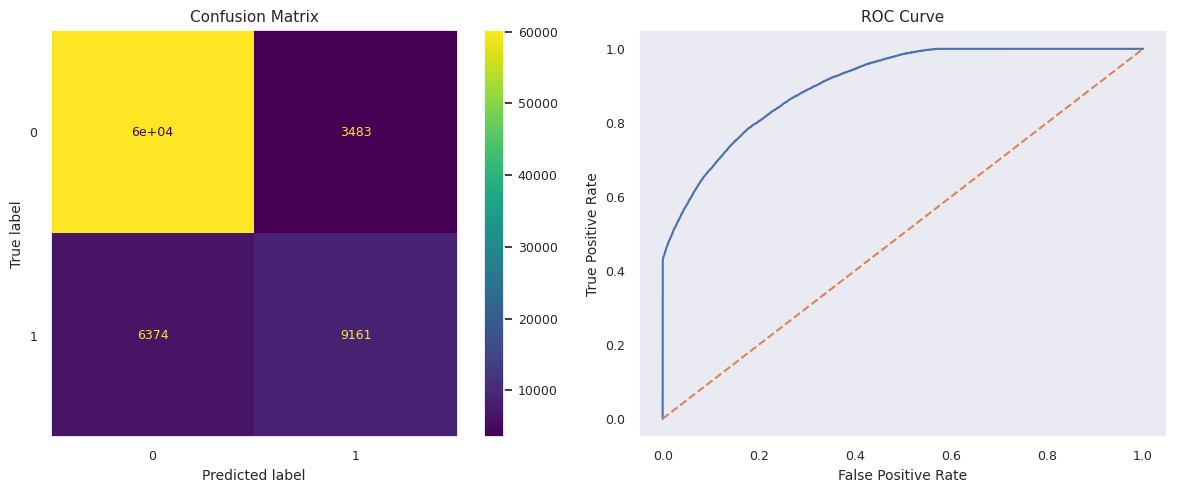

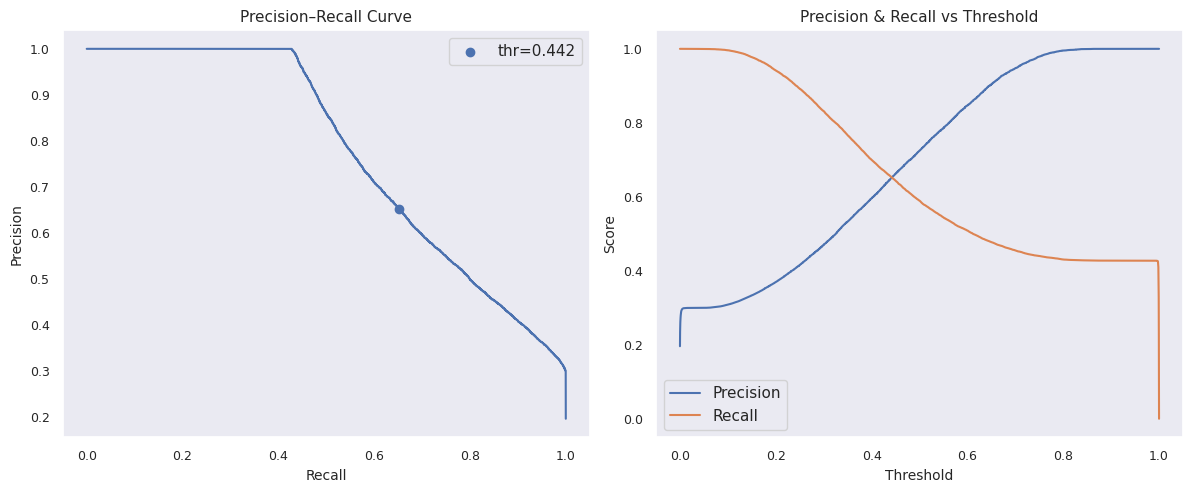

accuracy: 0.8755523571446607
precision: 0.7245333755140778
recall (TPR): 0.5897006758931446
f1_score: 0.6502005039213599
mcc: 0.5799931537980856
TPR: 0.5897006758931446
TNR: 0.9452969169637668
FPR: 0.054703083036233134
FNR: 0.4102993241068555
TP: 9161
TN: 60188
FP: 3483
FN: 6374
roc_auc: 0.9048352172189151
pr_auc: 0.7746761011873734


In [204]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
evaluate_classifier(y_test, y_pred, y_prob=y_pred_proba)

### Error Impact Summary

- **9,161** risky loans correctly detected, helping avoid potential credit losses.
- **6,374** risky loans missed, creating remaining default exposure.
- **60,188** safe loans correctly approved, contributing to portfolio revenue.
- **3,483** safe loans incorrectly rejected, resulting in missed lending opportunities.


#SMOTE

In [205]:
X_train.shape, y_train.shape

((316824, 56), (316824,))

In [206]:
smote = SMOTE(
    sampling_strategy="auto",  # make classes equal
    random_state=42,
    k_neighbors=5
)

X_train_sm, y_train_sm = smote.fit_resample(
    X_train, y_train
)

In [207]:
X_train.shape, y_train.shape

((316824, 56), (316824,))

In [208]:
X_train_sm.shape, y_train_sm.shape

((509372, 56), (509372,))

In [209]:
y_train_sm.value_counts(normalize=True)*100

loan_status
0    50.0
1    50.0
Name: proportion, dtype: float64

In [210]:
model = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [211]:
model.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=1000)

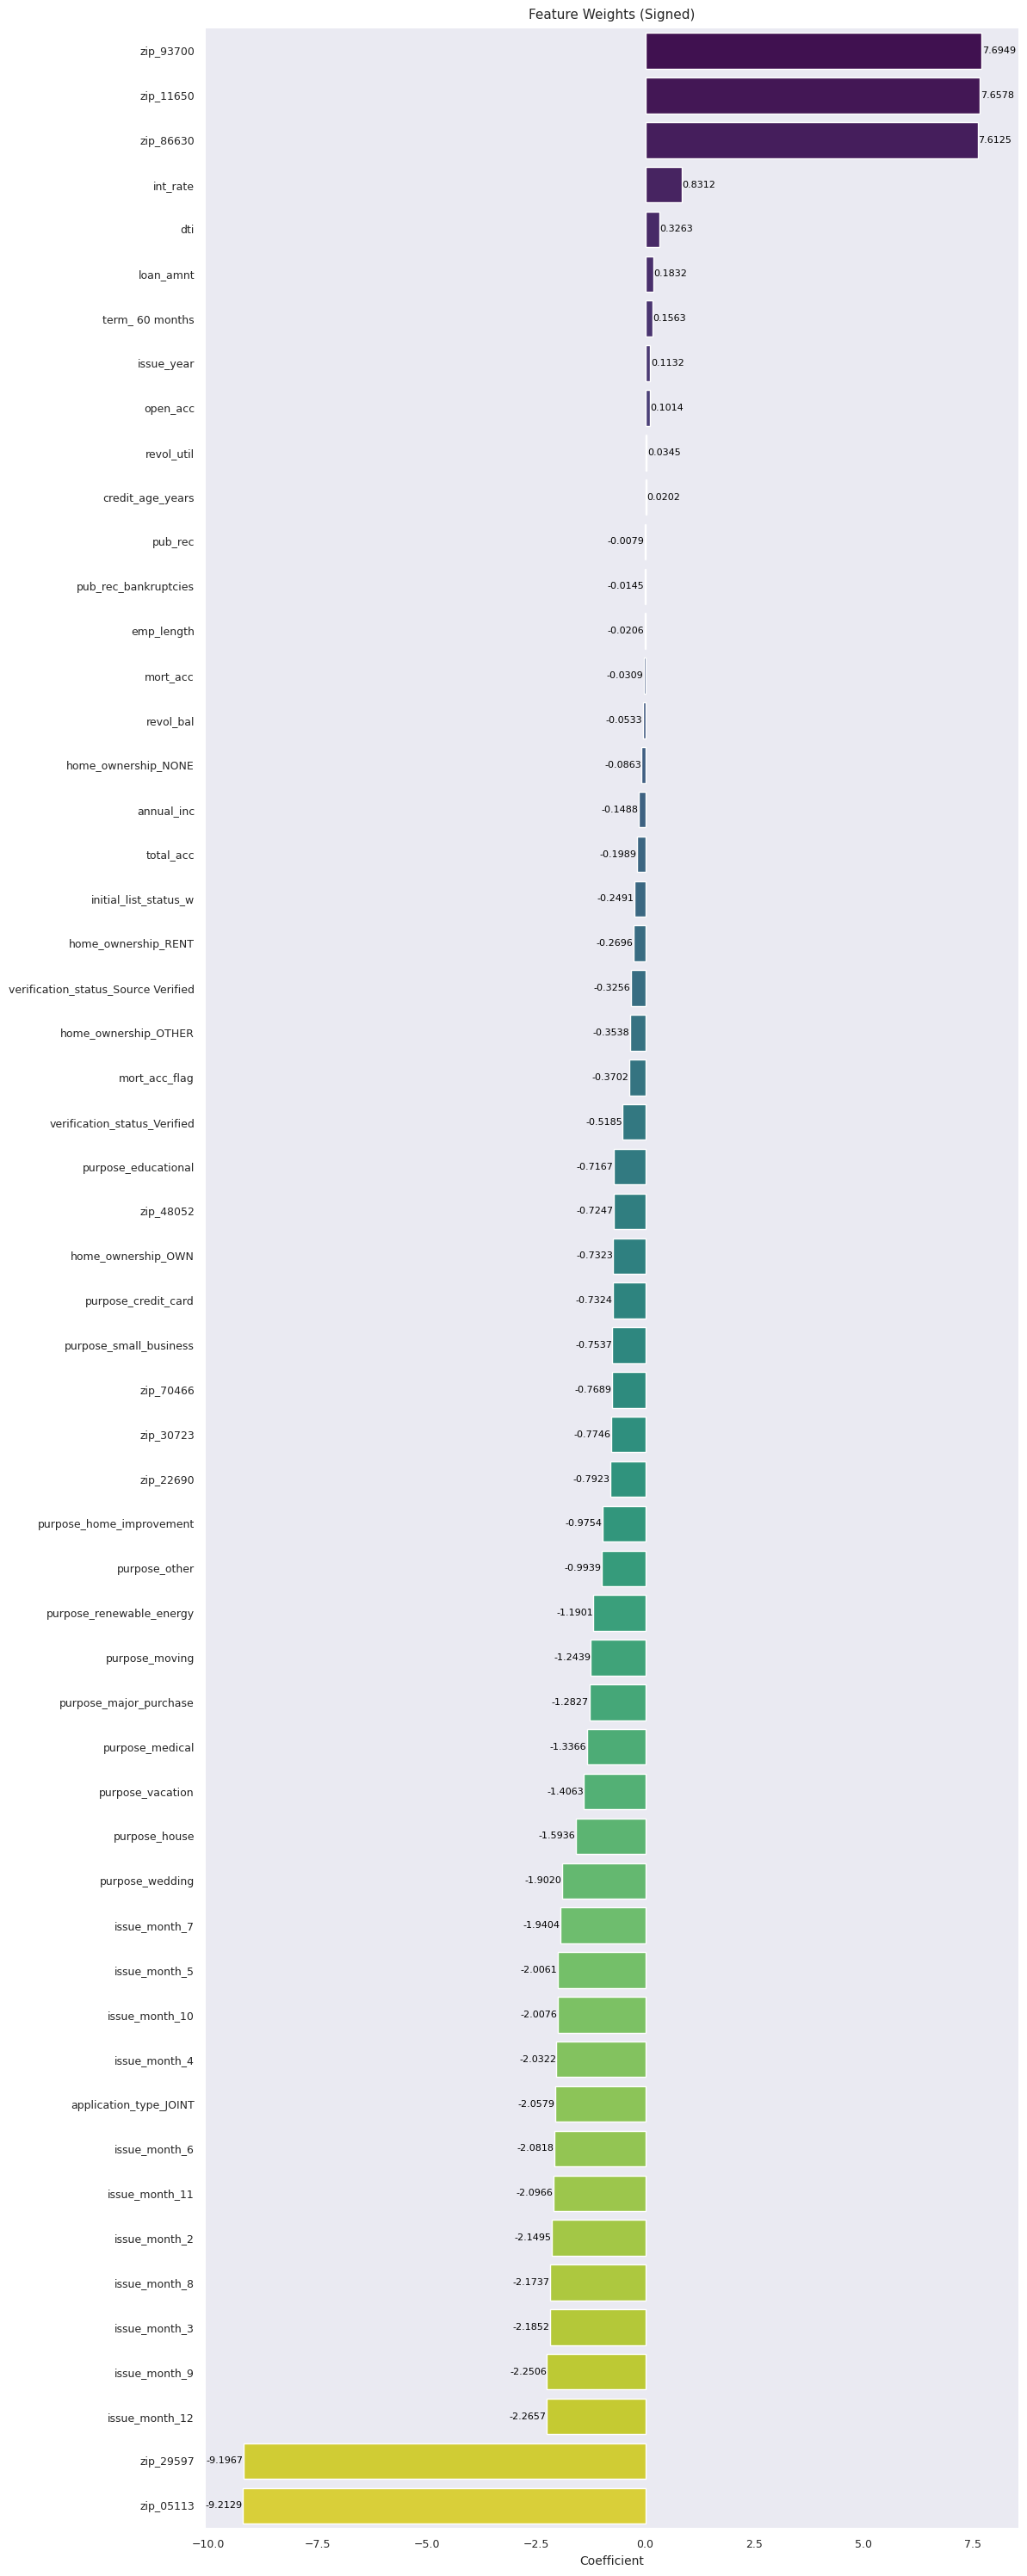

In [212]:
plot_model_weights(model_weights(model, X = X_train_sm), fig_size=(12,30))


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.85      0.83    254686
           1       0.84      0.80      0.82    254686

    accuracy                           0.83    509372
   macro avg       0.83      0.83      0.83    509372
weighted avg       0.83      0.83      0.83    509372



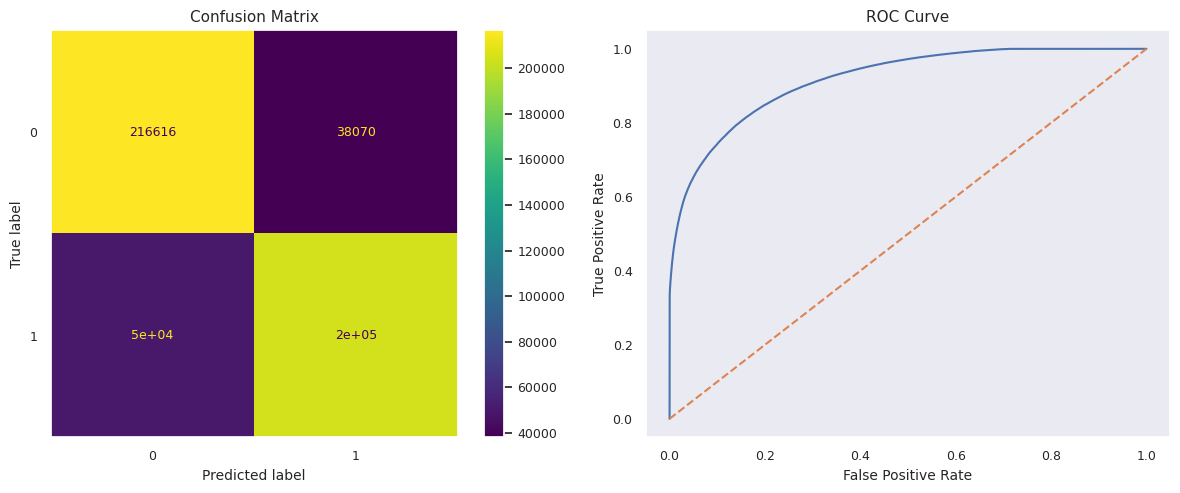

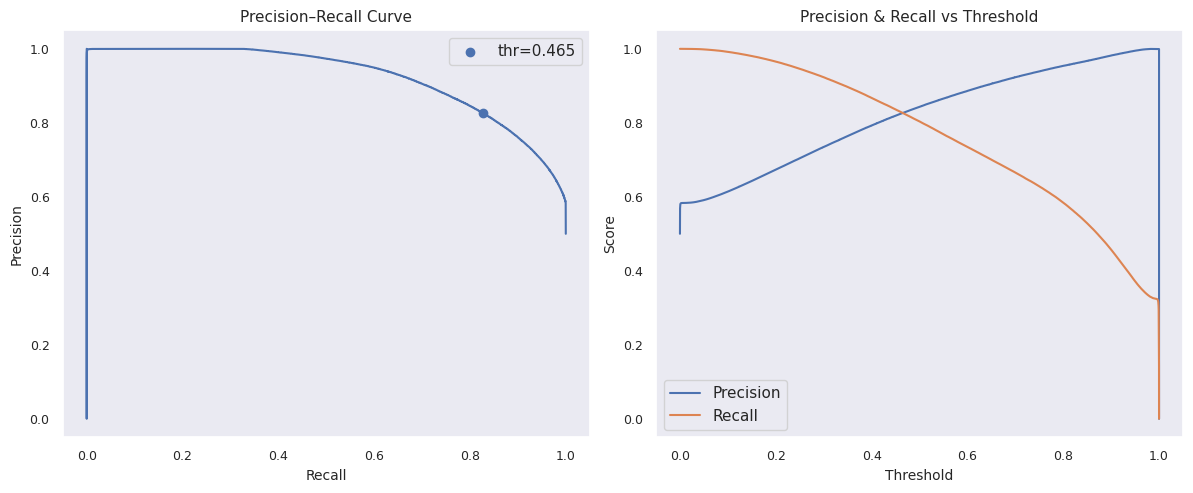

accuracy: 0.8271459758290601
precision: 0.84319072077898
recall (TPR): 0.80377013263391
f1_score: 0.823008653875147
mcc: 0.6550081755322256
TPR: 0.80377013263391
TNR: 0.8505218190242102
FPR: 0.1494781809757898
FNR: 0.19622986736609002
TP: 204709
TN: 216616
FP: 38070
FN: 49977
roc_auc: 0.9172109089832802
pr_auc: 0.9244949454294075


In [213]:
y_pred_train = model.predict(X_train_sm)
y_pred_proba_train = model.predict_proba(X_train_sm)[:, 1]
evaluate_classifier(y_train_sm, y_pred_train, y_prob=y_pred_proba_train)


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     63671
           1       0.50      0.61      0.55     15535

    accuracy                           0.80     79206
   macro avg       0.70      0.73      0.71     79206
weighted avg       0.82      0.80      0.81     79206



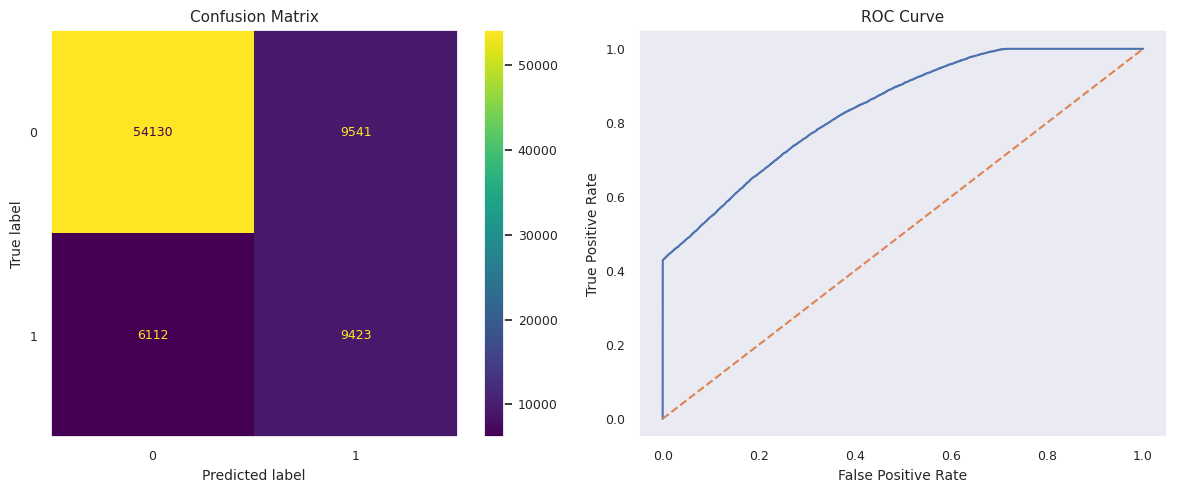

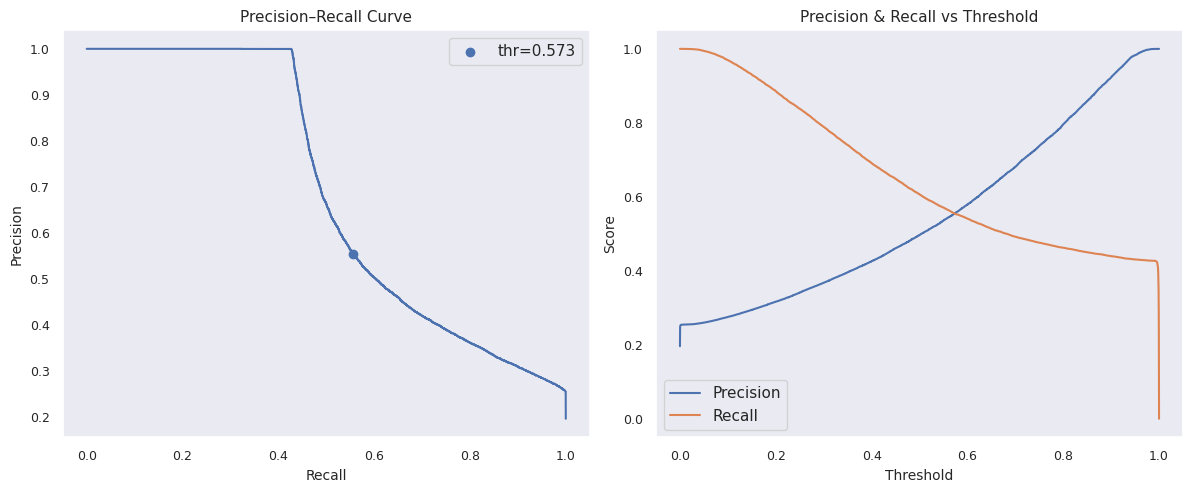

accuracy: 0.8023760826200035
precision: 0.4968888420164522
recall (TPR): 0.6065658191181204
f1_score: 0.5462767036725702
mcc: 0.4249710423954668
TPR: 0.6065658191181204
TNR: 0.8501515603650013
FPR: 0.14984843963499866
FNR: 0.39343418088187965
TP: 9423
TN: 54130
FP: 9541
FN: 6112
roc_auc: 0.8396517740302596
pr_auc: 0.6896453934218157


In [214]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
evaluate_classifier(y_test, y_pred, y_prob=y_pred_proba)

In [215]:
model = LogisticRegressionCV(
    Cs=[0.7,0.75,0.77],
    penalty="l1",
    solver="liblinear",
    cv=3,          # automatically stratified
    scoring="f1",
    max_iter=1500
)

In [216]:
X_small, _, y_small, _ = train_test_split(
    X_train_sm,
    y_train_sm,
    train_size=100000,   # sample size
    stratify=y_train_sm,
    random_state=42
)

In [217]:
model.fit(X_small, y_small)

LogisticRegressionCV(Cs=[0.7, 0.75, 0.77], cv=3, max_iter=1500, penalty='l1',
                     scoring='f1', solver='liblinear')

In [218]:
model.C_

array([0.7])

In [219]:
model = LogisticRegression(
    C=0.7,
    penalty="l1",
    solver="liblinear",
    max_iter=1500
)

In [220]:
model.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.7, max_iter=1500, penalty='l1', solver='liblinear')


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.85      0.83    254686
           1       0.84      0.80      0.82    254686

    accuracy                           0.83    509372
   macro avg       0.83      0.83      0.83    509372
weighted avg       0.83      0.83      0.83    509372



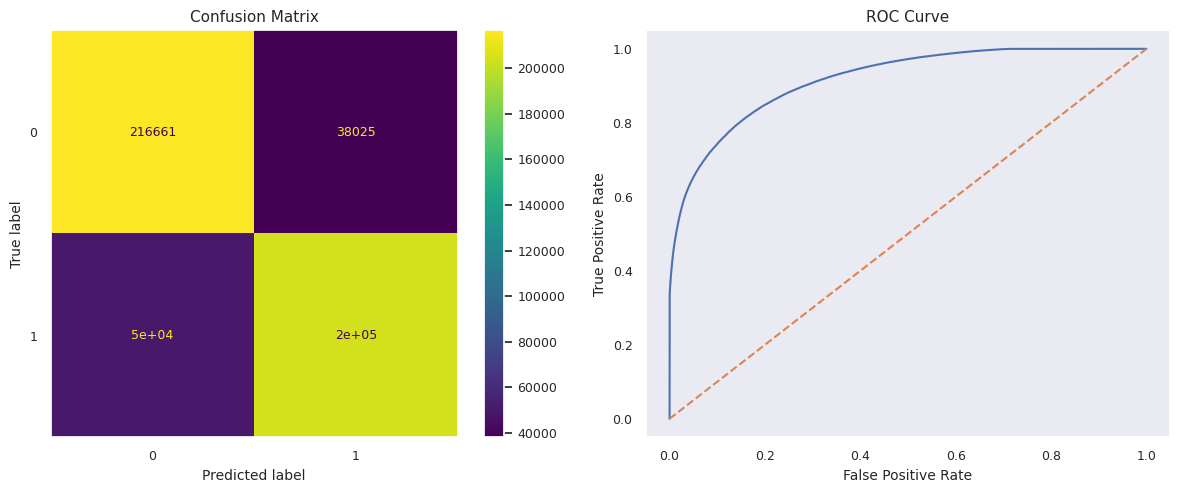

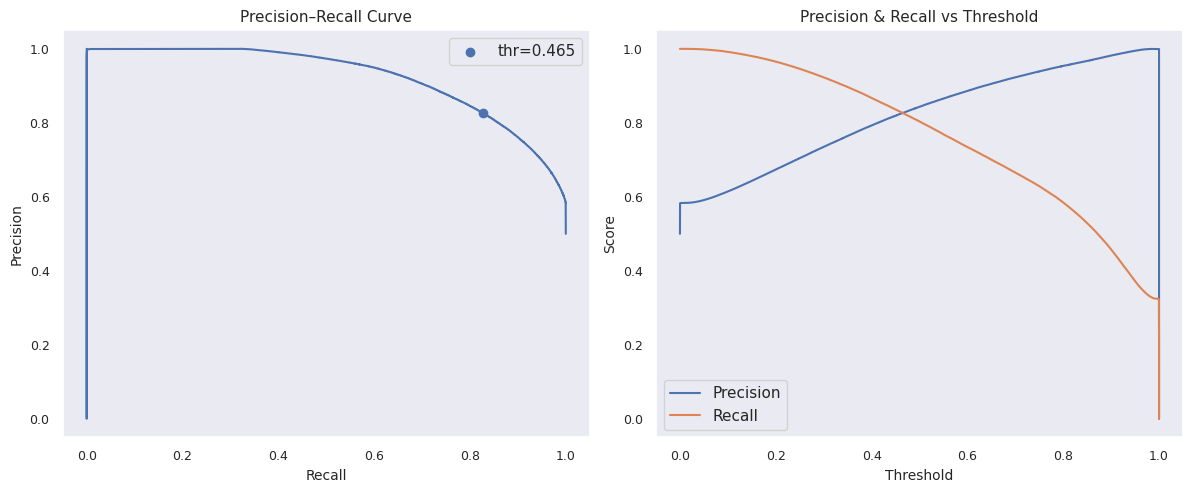

accuracy: 0.827208798284947
precision: 0.8433386480774222
recall (TPR): 0.8037190893885019
f1_score: 0.8230523494844262
mcc: 0.6551409654965981
TPR: 0.8037190893885019
TNR: 0.850698507181392
FPR: 0.14930149281860802
FNR: 0.19628091061149808
TP: 204696
TN: 216661
FP: 38025
FN: 49990
roc_auc: 0.9172224960252867
pr_auc: 0.9245058970409094


In [221]:
y_pred_train = model.predict(X_train_sm)
y_pred_proba_train = model.predict_proba(X_train_sm)[:, 1]
evaluate_classifier(y_train_sm, y_pred_train, y_prob=y_pred_proba_train)


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     63671
           1       0.50      0.61      0.55     15535

    accuracy                           0.80     79206
   macro avg       0.70      0.73      0.71     79206
weighted avg       0.82      0.80      0.81     79206



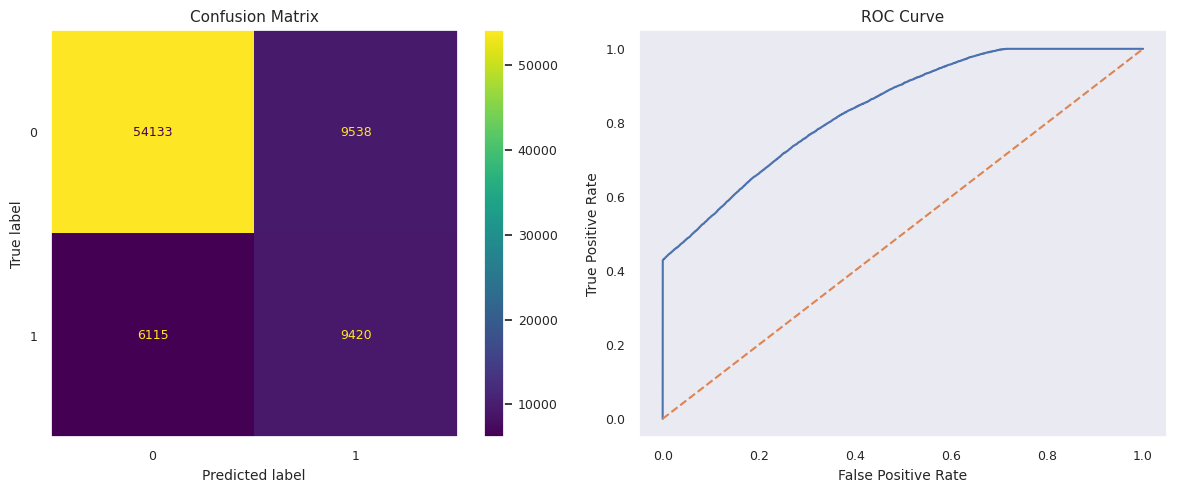

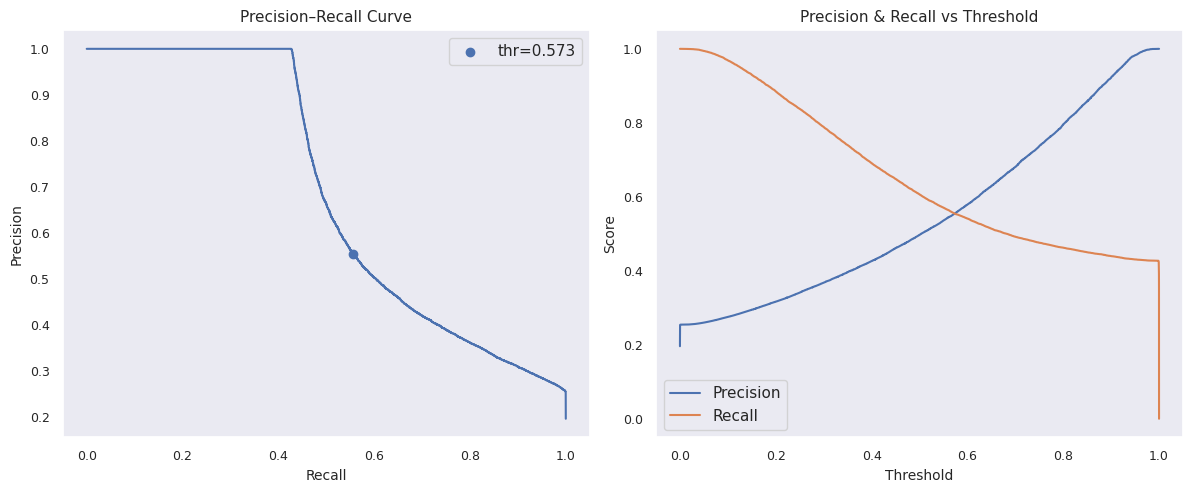

accuracy: 0.8023760826200035
precision: 0.49688785736892077
recall (TPR): 0.6063727067911169
f1_score: 0.5461977792595599
mcc: 0.42488125970865465
TPR: 0.6063727067911169
TNR: 0.8501986775769188
FPR: 0.14980132242308114
FNR: 0.3936272932088832
TP: 9420
TN: 54133
FP: 9538
FN: 6115
roc_auc: 0.8396453653615257
pr_auc: 0.6896570180403623


In [222]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
evaluate_classifier(y_test, y_pred, y_prob=y_pred_proba)

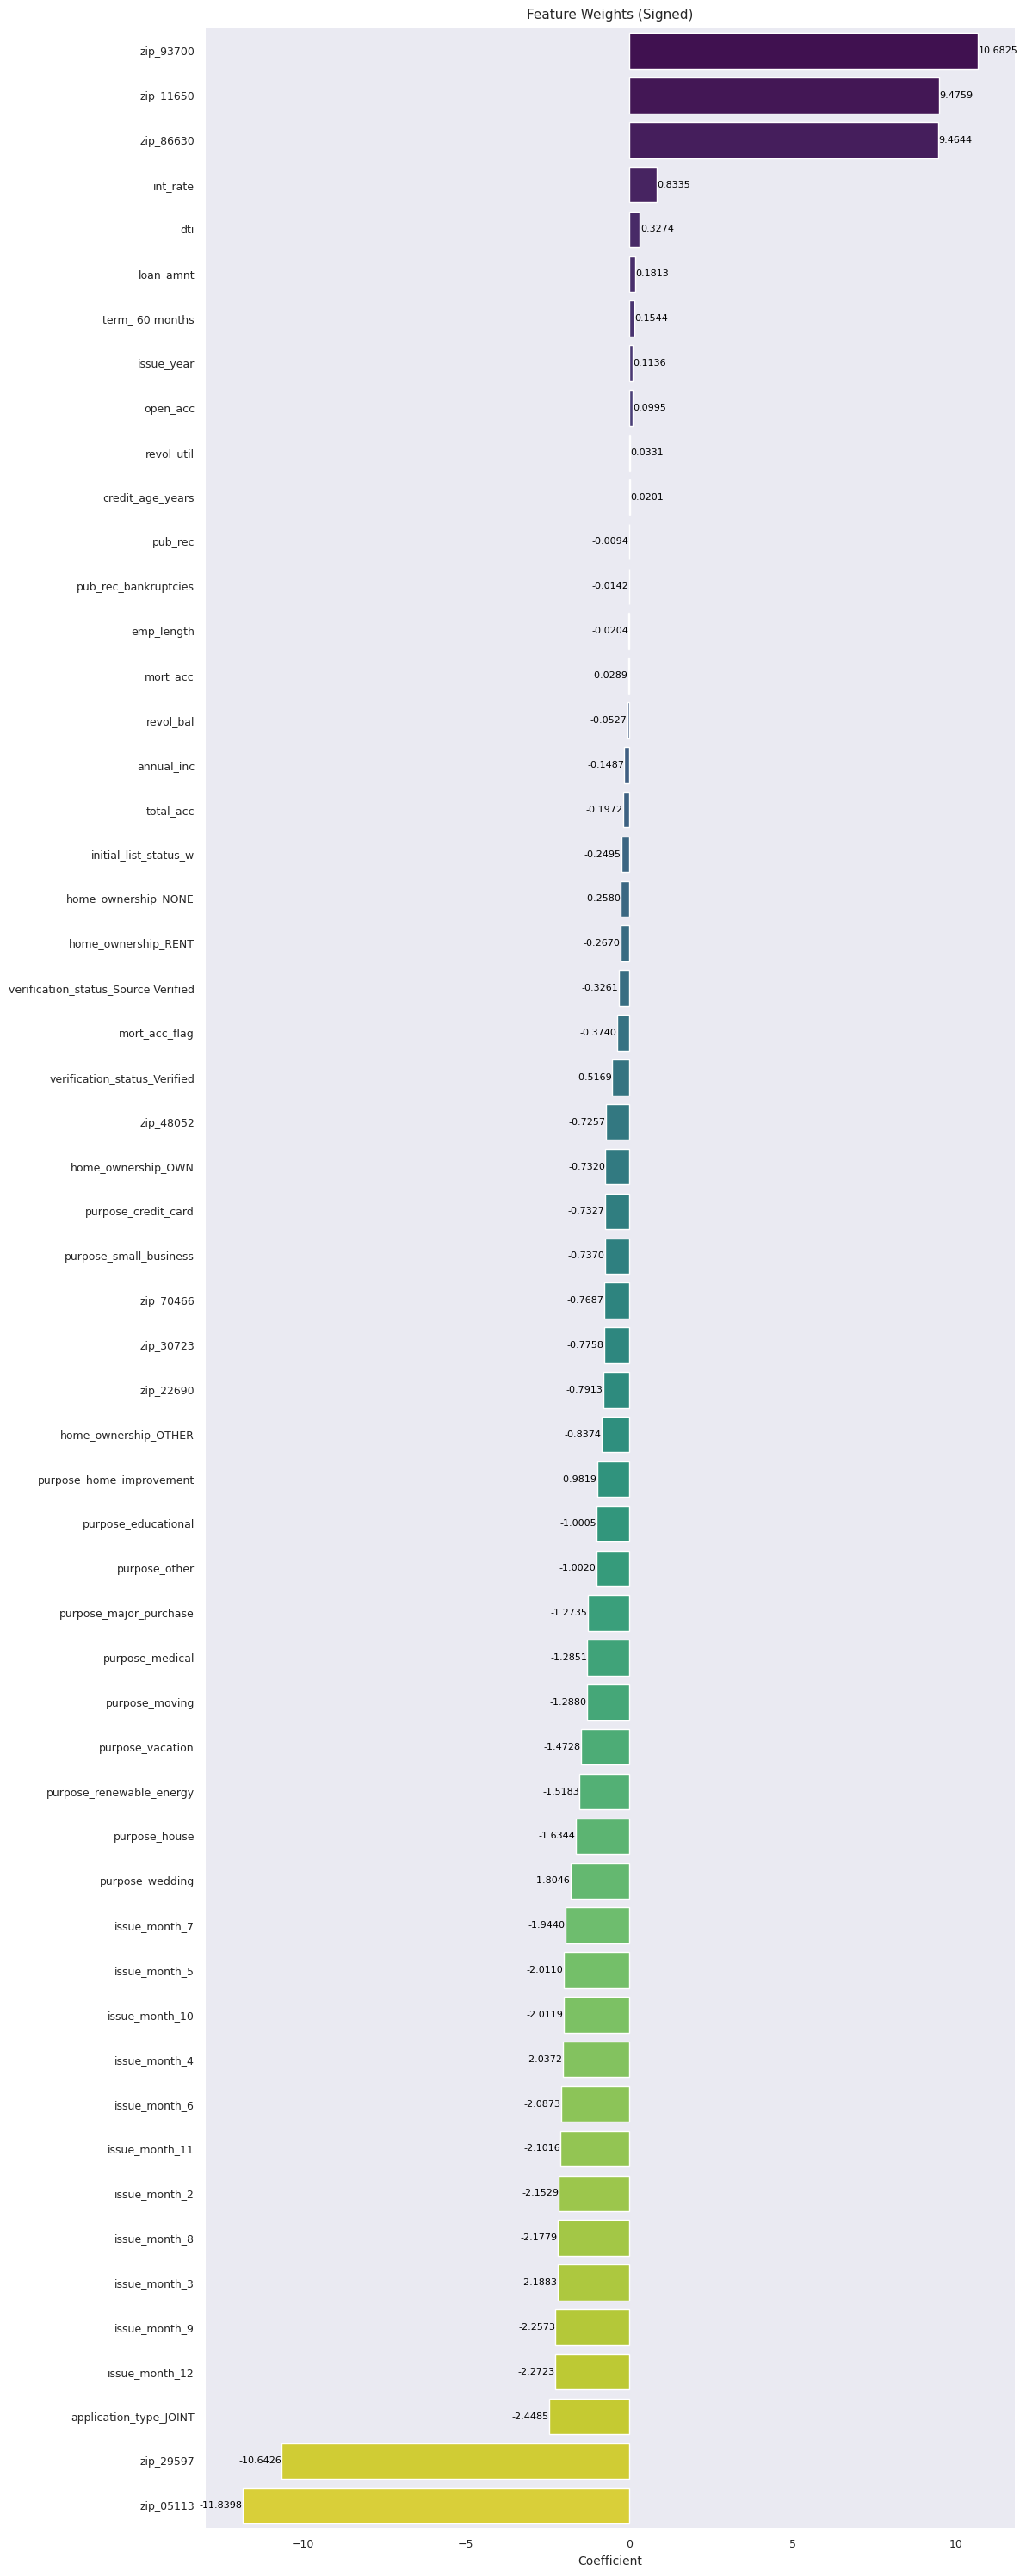

In [223]:
plot_model_weights(model_weights(model, X = X_train_sm), fig_size=(12,30))

### How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

We can improve this balance by:
- **Tuning the Prediction Threshold**
- **Improving Feature Engineering**
- **Handling Class Imbalance Better**
- **Trying Stronger Models**
- **Feature Selection & Regularization**

This helps detect real defaulters while reducing false positives.

---

### Since NPA (non-performing asset) is a real problem in this industry, it's important we play safe and shouldn’t disburse loans to anyone.

Non-performing assets (NPAs) are a major risk. If loans are given too freely, defaults increase and losses grow.

we can improve this by:
- **Regularly Retraining Model**
- **Adding Strong Repayment Capacity Features**


#Business Insights & Recomendations

- `int_rate`, `dti`, `loan_amnt`, `term`, `revol_util` : when this increases higher the default rate

- `application_type_joint`, `purpose`, `home_ownership`, `verification_status_verified`, `annual_inc`: when this increases lower the default rate

- Avoid pushing risky customers only through higher interest; combine with stricter approvals.
- Soft reject or tighter limits above safe DTI threshold.
- Slight risk premium or stricter limits for renters.
- Penalize thin credit history.
- Simulate thresholds and choose profit-optimal point.
- Instead of rejecting borderline customers: Offer them smaller loans.


**Business Recommendations**
---

- **Recommendation 1 — Implement Risk-Based Approval Strategy**
Low Risk ->	    Fast-track approval
Medium Risk ->	Approve with reduced amount or adjusted pricing
High Risk ->    Reject or send for manual review

- **Recommendation 2 — Introduce Repayment Capacity Guardrails**

    Approval decisions should include:

    - Installment-to-income limits,
    - Debt-to-income limits,
    - Credit utilization limits.

    These prevent lending beyond borrower capacity.

- **Recommendation 3 — Apply Demographic Risk Adjustments**

    Adjust exposure based on:

    - Employment stability,
    - Home ownership status,
    - Regional risk trends.

    This should influence loan size or review requirements rather than outright rejection.

- **Recommendation 4 — Implement Risk-Based Loan Sizing**

    Instead of rejecting borderline borrowers:

    - Reduce approved loan size,
    - Increase monitoring,
    - Offer safer loan structures.

    This preserves growth while controlling losses.

- **Recommendation 5 — Optimize Threshold Using Profit Simulation**

    Approval thresholds should be chosen based on:

    - Expected profit,
    - Default rate,
    - Approval volume.

This aligns model decisions with business goals.

**Recommendation 6 — Establish Portfolio Monitoring Framework**

Track:

    - Default rate trends,
    - Approval rate changes,
    - Regional performance,
    - Segment profitability.
Early drift detection prevents portfolio deterioration.

#Questionnaire

In [240]:
df = pd.read_csv('/content/logistic_regression.csv')

## 1. What percentage of customers have fully paid their Loan Amount?

Ans : 80.39 %

In [241]:
df.loan_status.value_counts(normalize=True)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: proportion, dtype: float64

##2. Comment about the correlation between Loan Amount and Installment features.

Ans: `loan_amnt` and `installment` is highly correlated. pearson co-efficient is ~ 0.95.

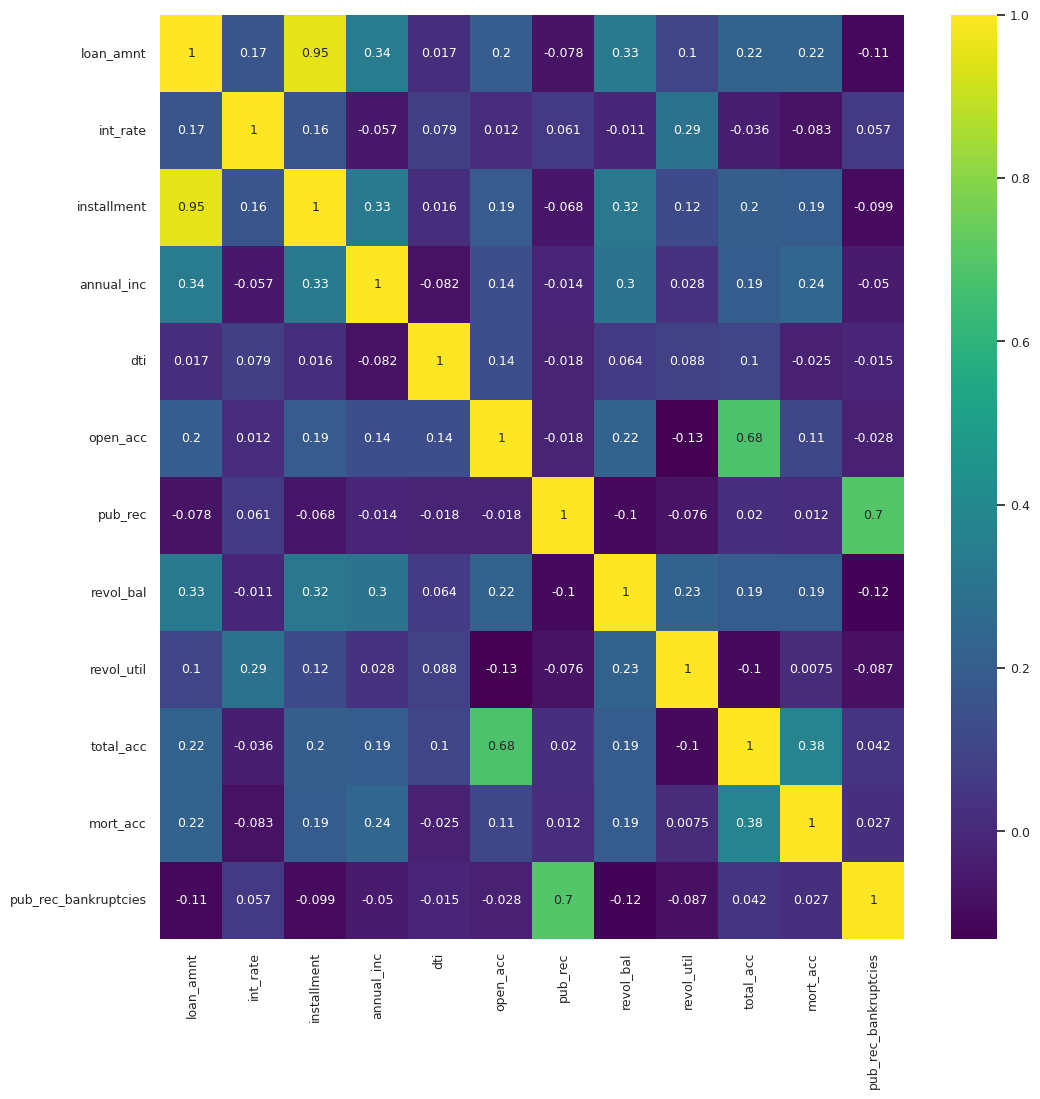

In [254]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.select_dtypes(include=['int','float']).corr(), annot=True, cmap = 'viridis', fmt = ".2g")
plt.show()

##3. The majority of people have home ownership as _______.

Ans: `Mortgage`(50.08%) and `Rent`(40.34%) totaling more than 90% people have mortgage or rent

In [243]:
df['home_ownership'].value_counts(normalize = True)*100

home_ownership
MORTGAGE    50.084085
RENT        40.347953
OWN          9.531096
OTHER        0.028281
NONE         0.007828
ANY          0.000758
Name: proportion, dtype: float64

##4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

Ans: True (around 93.7 %)

In [246]:
df.groupby('grade')['loan_status'].value_counts(normalize=True)*100

grade  loan_status
A      Fully Paid     93.712122
       Charged Off     6.287878
B      Fully Paid     87.426951
       Charged Off    12.573049
C      Fully Paid     78.819100
       Charged Off    21.180900
D      Fully Paid     71.132171
       Charged Off    28.867829
E      Fully Paid     62.636560
       Charged Off    37.363440
F      Fully Paid     57.212029
       Charged Off    42.787971
G      Fully Paid     52.161100
       Charged Off    47.838900
Name: proportion, dtype: float64

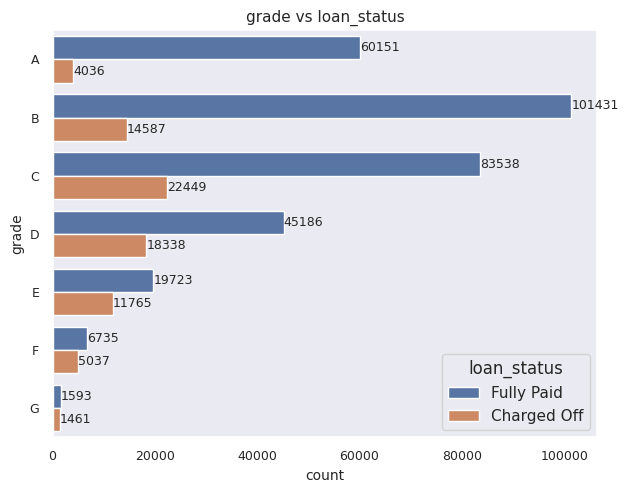

In [244]:
plot_categorical(df, ['grade'], sort_index=True)

## 5. Name the top 2 afforded job titles.

Ans: Teacher & Manager

In [253]:
df['emp_title'].value_counts().head(2)

emp_title
Teacher    4389
Manager    4250
Name: count, dtype: int64

## 6. Thinking from a bank's perspective, which metric should our primary focus be on..
    1. ROC AUC
    2. Precision
    3. Recall
    4. F1 Score

Ans:

As in our dataset class imbalance exists, roc_auc is not a good metric.

Precision is useful when we consider reducing NPA and Recall is useful when bank don't want to stop giving loans to borrower who will not deafault.

So from Banks pov F1 score is the right metric.

## 7. How does the gap in precision and recall affect the bank?

Ans:
In case of Gap between precision and recall there is two scenario:
1. Low precision, High recall:
```
Positive class = Default (bad loan)
Negative class = Non-default (good loan)

Then:
Low Precision -> Missed business opportunity

Precision answers:
Of loans predicted as risky, how many are actually risky?

Low precision means:
Many safe customers are predicted risky
Bank rejects good borrowers
Lost interest income
```
2. High precision, Low recall:
```
Low Recall -> Financial loss (NPA risk)

Recall answers:
Of all risky borrowers, how many did we correctly catch?

Low recall means:
Many risky borrowers are approved
Loans turn into NPAs
Direct financial loss
```

## 8. Which were the features that heavily affected the outcome?

Ans:
```
zip code
application_type_joint
issue_month
purpose
home_ownership
int_rate
verification_status
mort_acc
dti
```

## 9. Will the results be affected by geographical location? (Yes/No)

Ans: Yes, Most zip codes have impact on result as seen from the weights plot above.

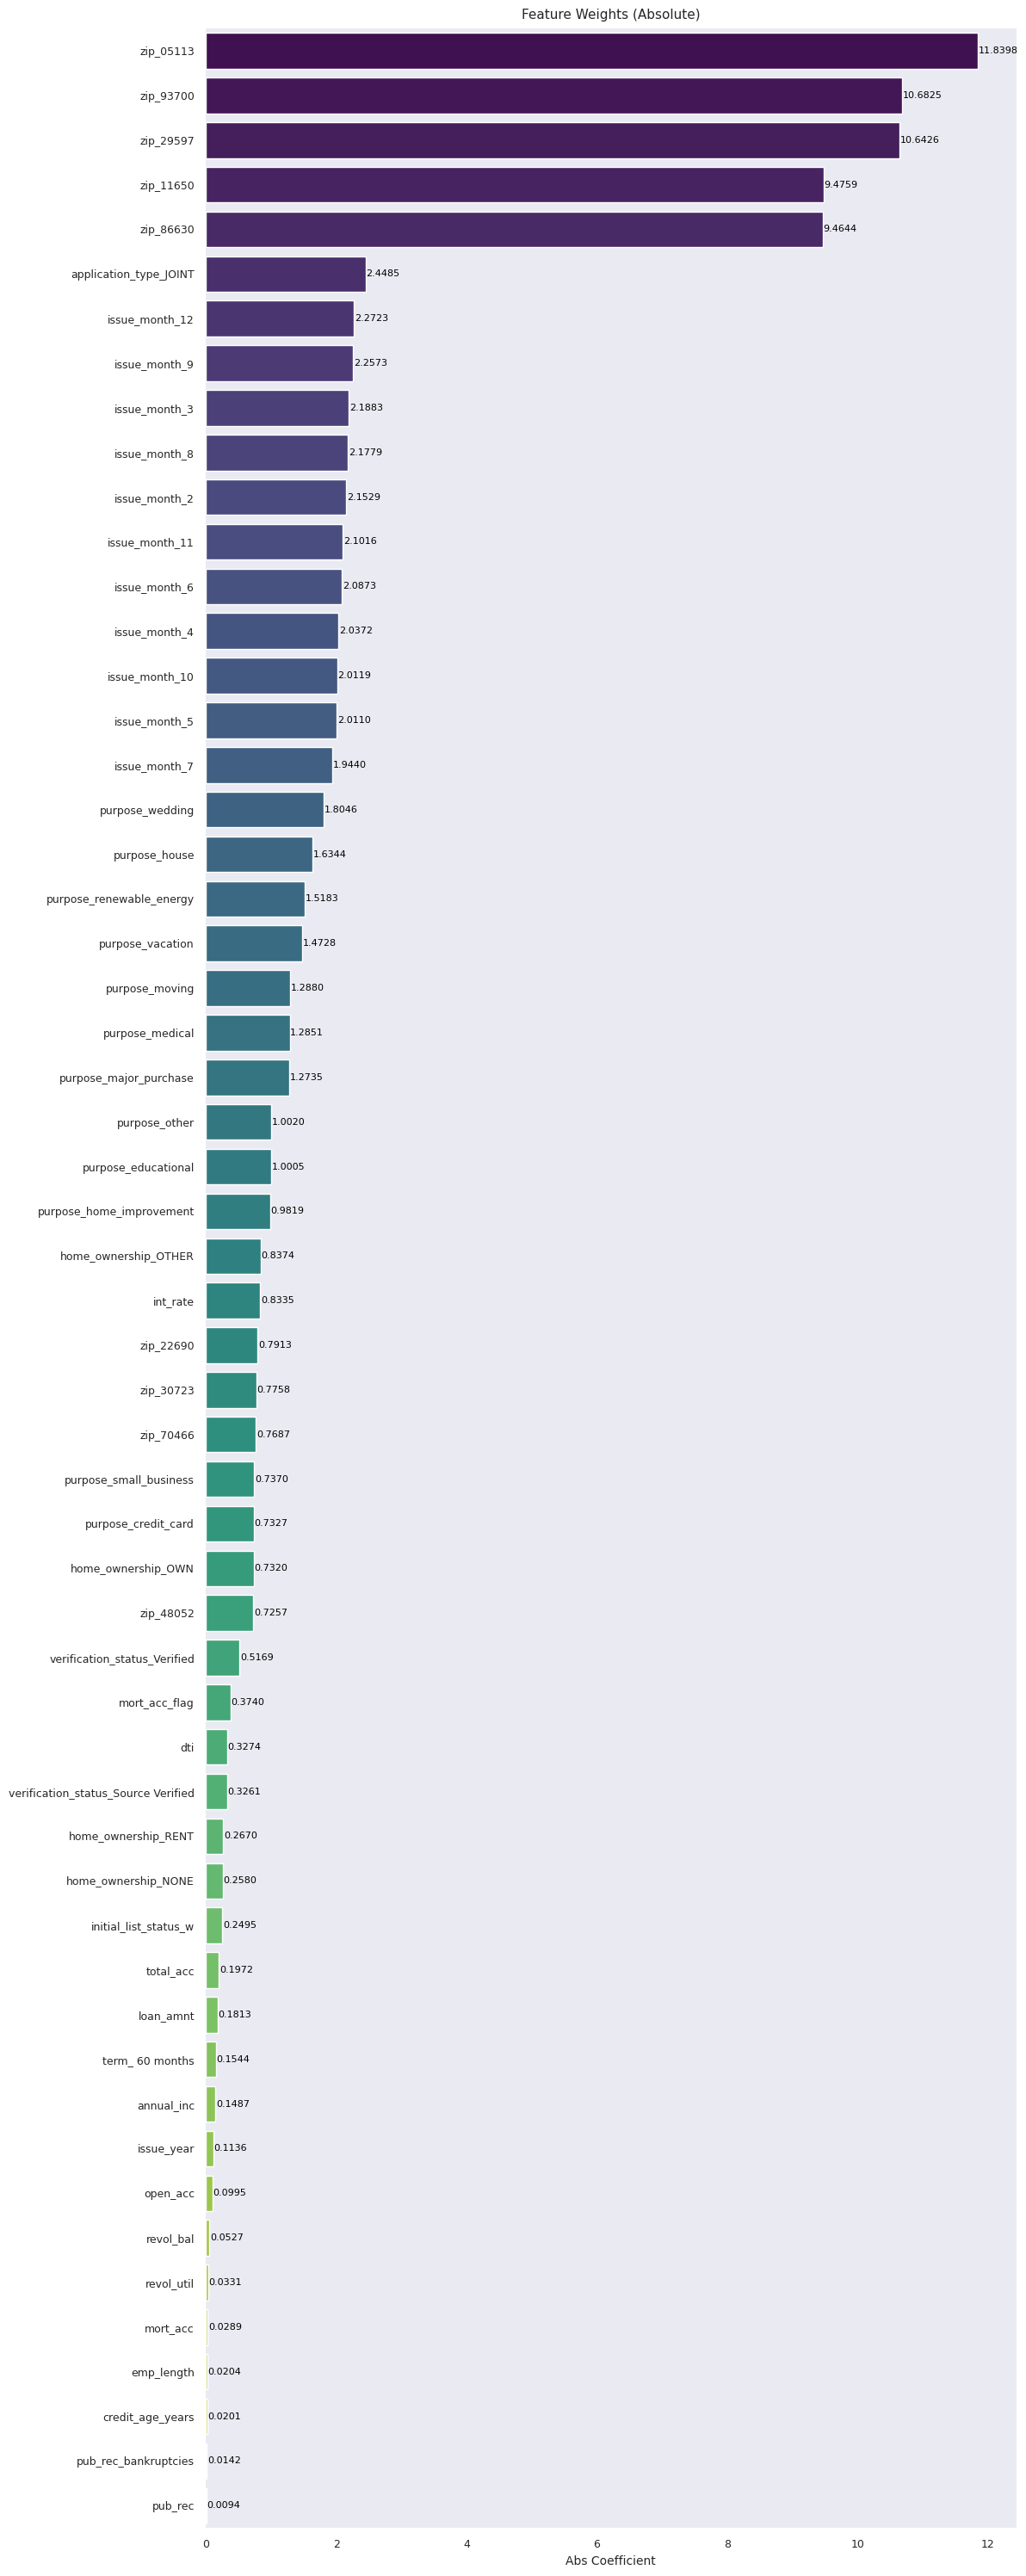

In [ ]:
plot_model_weights(model_weights(model, X = X_train), fig_size=(12,30), use_abs=True)